In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-virussign-resnet50-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = ResNet50(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 105s - loss: 1.3225 - acc: 0.6647 - val_loss: 4.8754 - val_acc: 0.0840
Epoch 2/100
9112/9112 [==============================] - 94s - loss: 0.8450 - acc: 0.7947 - val_loss: 15.5514 - val_acc: 0.0352
Epoch 3/100
9112/9112 [==============================] - 92s - loss: 0.7330 - acc: 0.8259 - val_loss: 15.3186 - val_acc: 0.0342
Epoch 4/100
9112/9112 [==============================] - 93s - loss: 0.5933 - acc: 0.8488 - val_loss: 1.7574 - val_acc: 0.5410
Epoch 5/100
9112/9112 [==============================] - 92s - loss: 0.2928 - acc: 0.9128 - val_loss: 0.3794 - val_acc: 0.8926
Epoch 6/100
9112/9112 [==============================] - 92s - loss: 0.2231 - acc: 0.9283 - val_loss: 0.4330 - val_acc: 0.8867
Epoch 7/100
9112/9112 [==============================] - 93s - loss: 0.2013 - acc: 0.9361 - val_loss: 0.3517 - val_acc: 0.9062
Epoch 8/100
9112/9112 [==============================] - 92s

9114/9114 [==============================] - 93s - loss: 0.1221 - acc: 0.9618 - val_loss: 0.3146 - val_acc: 0.9217
Epoch 27/100
9114/9114 [==============================] - 93s - loss: 0.1131 - acc: 0.9647 - val_loss: 0.3093 - val_acc: 0.9168
Epoch 28/100
9114/9114 [==============================] - 93s - loss: 0.1256 - acc: 0.9600 - val_loss: 0.4047 - val_acc: 0.9012
Epoch 29/100
9114/9114 [==============================] - 93s - loss: 0.1011 - acc: 0.9685 - val_loss: 0.2917 - val_acc: 0.9256
Epoch 30/100
9114/9114 [==============================] - 93s - loss: 0.0741 - acc: 0.9765 - val_loss: 0.5894 - val_acc: 0.9119
Epoch 31/100
9114/9114 [==============================] - 93s - loss: 0.0761 - acc: 0.9742 - val_loss: 0.5998 - val_acc: 0.9080
Epoch 32/100
9114/9114 [==============================] - 92s - loss: 0.0681 - acc: 0.9778 - val_loss: 0.3232 - val_acc: 0.9295
Epoch 33/100
9114/9114 [==============================] - 93s - loss: 0.0609 - acc: 0.9796 - val_loss: 0.3563 - val_a

9116/9116 [==============================] - 93s - loss: 0.0498 - acc: 0.9827 - val_loss: 0.3745 - val_acc: 0.9265
Epoch 54/100
9116/9116 [==============================] - 93s - loss: 0.0334 - acc: 0.9891 - val_loss: 0.3566 - val_acc: 0.9216
Epoch 55/100
9116/9116 [==============================] - 93s - loss: 0.0252 - acc: 0.9919 - val_loss: 0.3599 - val_acc: 0.9304
Epoch 56/100
9116/9116 [==============================] - 93s - loss: 0.0343 - acc: 0.9877 - val_loss: 0.4363 - val_acc: 0.9275
Epoch 57/100
9116/9116 [==============================] - 92s - loss: 0.0222 - acc: 0.9933 - val_loss: 0.3869 - val_acc: 0.9265
Epoch 58/100
9116/9116 [==============================] - 92s - loss: 0.0160 - acc: 0.9952 - val_loss: 0.3774 - val_acc: 0.9324
Epoch 59/100
9116/9116 [==============================] - 93s - loss: 0.0170 - acc: 0.9951 - val_loss: 0.4352 - val_acc: 0.9255
Epoch 60/100
9116/9116 [==============================] - 93s - loss: 0.0321 - acc: 0.9895 - val_loss: 0.3990 - val_a

9120/9120 [==============================] - 93s - loss: 0.2330 - acc: 0.9268 - val_loss: 0.6572 - val_acc: 0.8425
Epoch 17/100
9120/9120 [==============================] - 93s - loss: 0.2088 - acc: 0.9333 - val_loss: 0.4189 - val_acc: 0.8917
Epoch 18/100
9120/9120 [==============================] - 93s - loss: 0.1954 - acc: 0.9360 - val_loss: 0.3840 - val_acc: 0.8996
Epoch 19/100
9120/9120 [==============================] - 93s - loss: 0.1791 - acc: 0.9440 - val_loss: 0.4726 - val_acc: 0.8730
Epoch 20/100
9120/9120 [==============================] - 93s - loss: 0.1783 - acc: 0.9435 - val_loss: 0.5155 - val_acc: 0.8858
Epoch 21/100
9120/9120 [==============================] - 93s - loss: 0.1614 - acc: 0.9479 - val_loss: 0.3985 - val_acc: 0.8986
Epoch 22/100
9120/9120 [==============================] - 93s - loss: 0.1430 - acc: 0.9537 - val_loss: 0.4657 - val_acc: 0.8996
Epoch 23/100
9120/9120 [==============================] - 93s - loss: 0.1154 - acc: 0.9634 - val_loss: 0.7672 - val_a

9120/9120 [==============================] - 93s - loss: 0.0364 - acc: 0.9893 - val_loss: 0.4062 - val_acc: 0.9222
Epoch 43/100
9120/9120 [==============================] - 93s - loss: 0.0534 - acc: 0.9823 - val_loss: 0.3930 - val_acc: 0.9291
Epoch 44/100
9120/9120 [==============================] - 93s - loss: 0.0517 - acc: 0.9808 - val_loss: 0.4712 - val_acc: 0.9144
Epoch 45/100
9120/9120 [==============================] - 93s - loss: 0.0520 - acc: 0.9826 - val_loss: 0.3511 - val_acc: 0.9262
Epoch 46/100
9120/9120 [==============================] - 93s - loss: 0.0393 - acc: 0.9875 - val_loss: 0.4237 - val_acc: 0.9144
Epoch 47/100
9120/9120 [==============================] - 93s - loss: 0.0311 - acc: 0.9899 - val_loss: 0.4271 - val_acc: 0.9242
Epoch 48/100
9120/9120 [==============================] - 93s - loss: 0.0334 - acc: 0.9887 - val_loss: 0.4067 - val_acc: 0.9281
Epoch 49/100
9120/9120 [==============================] - 93s - loss: 0.0591 - acc: 0.9814 - val_loss: 1.6579 - val_a

9125/9125 [==============================] - 93s - loss: 0.8136 - acc: 0.8170 - val_loss: 1.6820 - val_acc: 0.7280
Epoch 6/100
9125/9125 [==============================] - 93s - loss: 0.7170 - acc: 0.8339 - val_loss: 0.5516 - val_acc: 0.8388
Epoch 7/100
9125/9125 [==============================] - 93s - loss: 0.6894 - acc: 0.8540 - val_loss: 0.6039 - val_acc: 0.8180
Epoch 8/100
9125/9125 [==============================] - 93s - loss: 0.9022 - acc: 0.8009 - val_loss: 2.7097 - val_acc: 0.5312
Epoch 9/100
9125/9125 [==============================] - 93s - loss: 0.6243 - acc: 0.8467 - val_loss: 0.8862 - val_acc: 0.8427
Epoch 10/100
9125/9125 [==============================] - 93s - loss: 0.4884 - acc: 0.8732 - val_loss: 0.4162 - val_acc: 0.8754
Epoch 11/100
9125/9125 [==============================] - 92s - loss: 0.3960 - acc: 0.8888 - val_loss: 0.6116 - val_acc: 0.8645
Epoch 12/100
9125/9125 [==============================] - 93s - loss: 0.3250 - acc: 0.9008 - val_loss: 0.3445 - val_acc: 

9127/9127 [==============================] - 93s - loss: 0.0645 - acc: 0.9802 - val_loss: 0.9222 - val_acc: 0.7998
Epoch 33/100
9127/9127 [==============================] - 93s - loss: 0.0543 - acc: 0.9829 - val_loss: 0.3113 - val_acc: 0.9336
Epoch 34/100
9127/9127 [==============================] - 93s - loss: 0.1380 - acc: 0.9567 - val_loss: 0.7618 - val_acc: 0.8672
Epoch 35/100
9127/9127 [==============================] - 93s - loss: 0.0781 - acc: 0.9751 - val_loss: 0.3063 - val_acc: 0.9316
Epoch 36/100
9127/9127 [==============================] - 93s - loss: 0.0430 - acc: 0.9873 - val_loss: 0.3070 - val_acc: 0.9376
Epoch 37/100
9127/9127 [==============================] - 93s - loss: 0.0422 - acc: 0.9879 - val_loss: 0.3573 - val_acc: 0.9257
Epoch 38/100
9127/9127 [==============================] - 92s - loss: 0.0268 - acc: 0.9911 - val_loss: 0.3485 - val_acc: 0.9425
Epoch 39/100
9127/9127 [==============================] - 93s - loss: 0.0310 - acc: 0.9910 - val_loss: 0.4553 - val_a

9128/9128 [==============================] - 93s - loss: 0.0178 - acc: 0.9945 - val_loss: 0.3855 - val_acc: 0.9246
Epoch 60/100
9128/9128 [==============================] - 93s - loss: 0.0469 - acc: 0.9846 - val_loss: 0.3443 - val_acc: 0.9435
Epoch 61/100
9128/9128 [==============================] - 93s - loss: 0.0170 - acc: 0.9940 - val_loss: 0.3854 - val_acc: 0.9365
Epoch 62/100
9128/9128 [==============================] - 92s - loss: 0.0096 - acc: 0.9965 - val_loss: 0.3922 - val_acc: 0.9425
Epoch 63/100
9128/9128 [==============================] - 93s - loss: 0.0136 - acc: 0.9951 - val_loss: 0.3862 - val_acc: 0.9365
Epoch 64/100
9128/9128 [==============================] - 93s - loss: 0.0176 - acc: 0.9939 - val_loss: 0.3657 - val_acc: 0.9435
Epoch 65/100
9128/9128 [==============================] - 92s - loss: 0.0209 - acc: 0.9942 - val_loss: 0.3890 - val_acc: 0.9306
Epoch 66/100
9128/9128 [==============================] - 92s - loss: 0.0143 - acc: 0.9959 - val_loss: 0.3656 - val_a

9130/9130 [==============================] - 95s - loss: 0.1047 - acc: 0.9662 - val_loss: 0.3109 - val_acc: 0.9165
Epoch 23/100
9130/9130 [==============================] - 95s - loss: 0.0866 - acc: 0.9728 - val_loss: 0.3201 - val_acc: 0.9284
Epoch 24/100
9130/9130 [==============================] - 95s - loss: 0.0777 - acc: 0.9746 - val_loss: 0.3713 - val_acc: 0.9155
Epoch 25/100
9130/9130 [==============================] - 95s - loss: 0.0826 - acc: 0.9734 - val_loss: 0.3093 - val_acc: 0.9135
Epoch 26/100
9130/9130 [==============================] - 95s - loss: 0.0792 - acc: 0.9745 - val_loss: 0.3372 - val_acc: 0.9215
Epoch 27/100
9130/9130 [==============================] - 95s - loss: 0.1554 - acc: 0.9621 - val_loss: 10.7257 - val_acc: 0.2654
Epoch 28/100
9130/9130 [==============================] - 95s - loss: 0.7091 - acc: 0.8499 - val_loss: 13.0436 - val_acc: 0.0557
Epoch 29/100
9130/9130 [==============================] - 95s - loss: 0.5147 - acc: 0.9019 - val_loss: 0.8009 - val

9130/9130 [==============================] - 94s - loss: 0.0071 - acc: 0.9976 - val_loss: 1.5512 - val_acc: 0.8688
Epoch 87/100
9130/9130 [==============================] - 95s - loss: 0.0034 - acc: 0.9988 - val_loss: 1.1664 - val_acc: 0.8837
Epoch 88/100
9130/9130 [==============================] - 95s - loss: 0.0184 - acc: 0.9942 - val_loss: 1.8488 - val_acc: 0.8469
Epoch 89/100
9130/9130 [==============================] - 95s - loss: 0.0105 - acc: 0.9969 - val_loss: 1.0200 - val_acc: 0.8897
Epoch 90/100
9130/9130 [==============================] - 95s - loss: 0.0340 - acc: 0.9895 - val_loss: 1.0564 - val_acc: 0.8787
Epoch 91/100
9130/9130 [==============================] - 93s - loss: 0.0323 - acc: 0.9888 - val_loss: 1.0018 - val_acc: 0.8817
Epoch 92/100
9130/9130 [==============================] - 92s - loss: 0.0204 - acc: 0.9929 - val_loss: 0.4040 - val_acc: 0.9304
Epoch 93/100
9130/9130 [==============================] - 91s - loss: 0.0094 - acc: 0.9967 - val_loss: 0.3972 - val_a

9132/9132 [==============================] - 92s - loss: 0.0349 - acc: 0.9878 - val_loss: 0.5146 - val_acc: 0.9203
Epoch 50/100
9132/9132 [==============================] - 92s - loss: 0.0316 - acc: 0.9897 - val_loss: 0.4002 - val_acc: 0.9303
Epoch 51/100
9132/9132 [==============================] - 92s - loss: 0.0217 - acc: 0.9929 - val_loss: 0.3629 - val_acc: 0.9283
Epoch 52/100
9132/9132 [==============================] - 92s - loss: 0.0375 - acc: 0.9866 - val_loss: 0.4852 - val_acc: 0.9114
Epoch 53/100
9132/9132 [==============================] - 92s - loss: 0.0600 - acc: 0.9805 - val_loss: 0.3864 - val_acc: 0.9163
Epoch 54/100
9132/9132 [==============================] - 92s - loss: 0.0340 - acc: 0.9897 - val_loss: 0.4226 - val_acc: 0.9084
Epoch 55/100
9132/9132 [==============================] - 92s - loss: 0.0302 - acc: 0.9901 - val_loss: 0.3169 - val_acc: 0.9303
Epoch 56/100
9132/9132 [==============================] - 91s - loss: 0.0429 - acc: 0.9870 - val_loss: 0.4025 - val_a

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8690


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

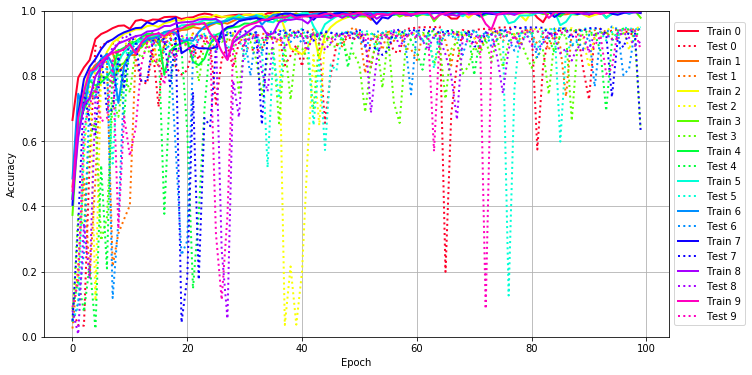

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

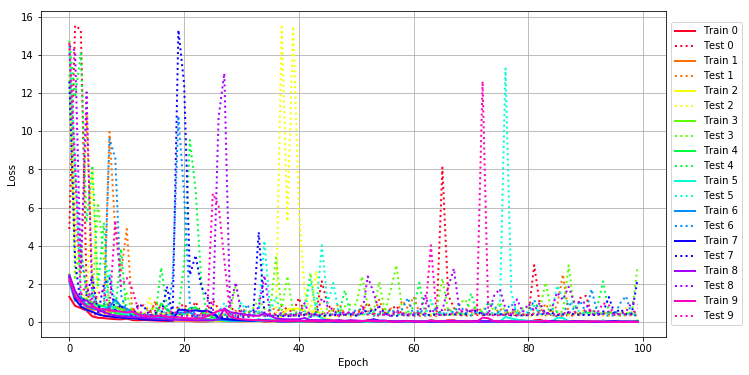

In [12]:
plot_loss(history)

Plotting the confusion matrix


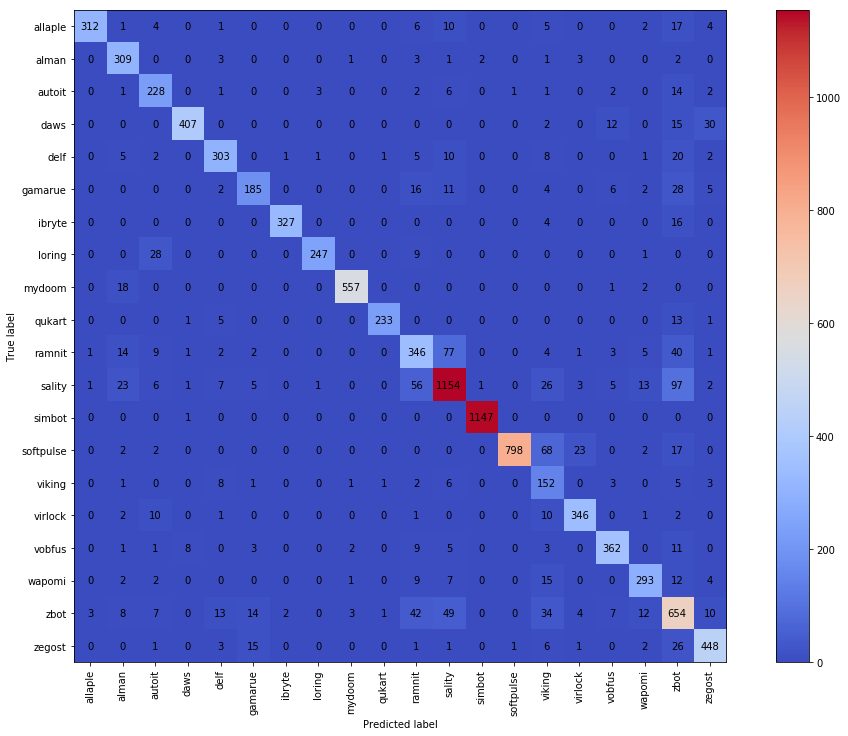

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


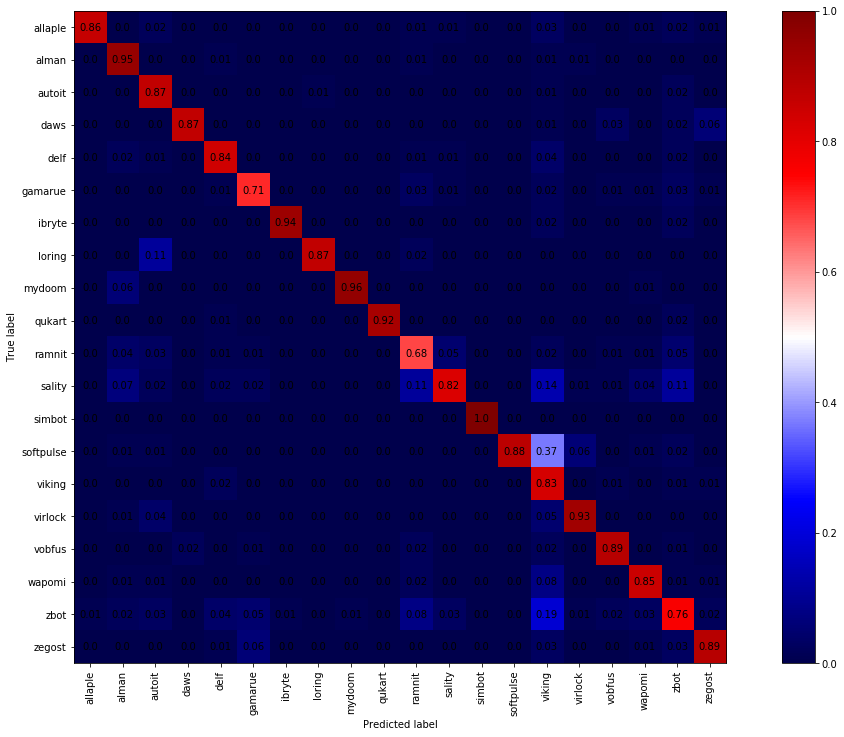

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


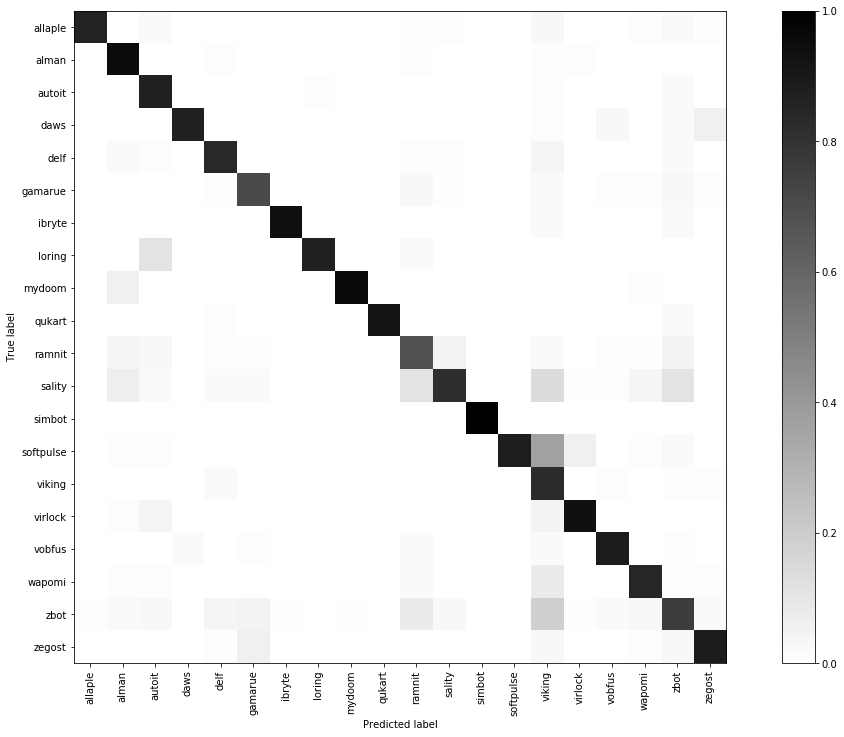

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


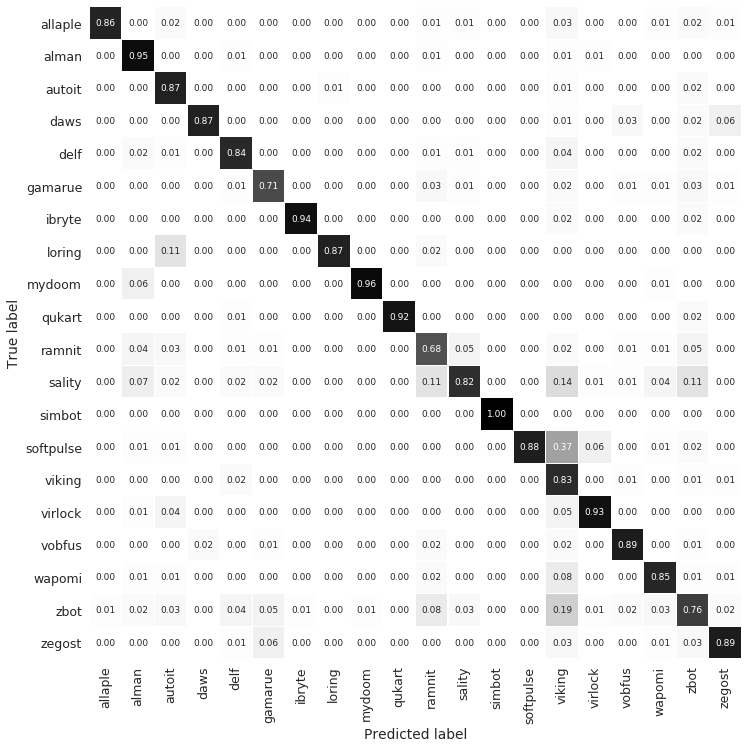

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
for h in history:
    print(h.history)

{'acc': [0.66472783153574122, 0.79466637401229145, 0.82594381046462628, 0.84877085172889311, 0.91275241439859522, 0.92833625987708512, 0.93612818272099152, 0.94633450400316477, 0.95335820905988522, 0.95467515374820833, 0.94392010546023641, 0.96872256365232656, 0.97223441615452155, 0.96674714672450335, 0.9727831432126508, 0.97201492547779567, 0.98002633899842784, 0.98112379290536378, 0.98123353819139592, 0.97431957868236108, 0.97805092196594323, 0.97980684811237928, 0.98715978928884984, 0.99100087806778692, 0.98880597025391515, 0.98167251975417036, 0.97958735743565351, 0.98397717295873577, 0.98606233538191401, 0.98781826163301145, 0.98748902546093065, 0.98825724330044717, 0.98309920993784838, 0.98386742756804213, 0.99209833187006147, 0.99242756804214227, 0.99264705887586013, 0.98013608438912136, 0.98781826163301145, 0.98968393337946381, 0.98452589991220374, 0.9935250219490781, 0.99626865671641796, 0.99637840210711148, 0.989354697207383, 0.9834284460052678, 0.9854038630377524, 0.99253731

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

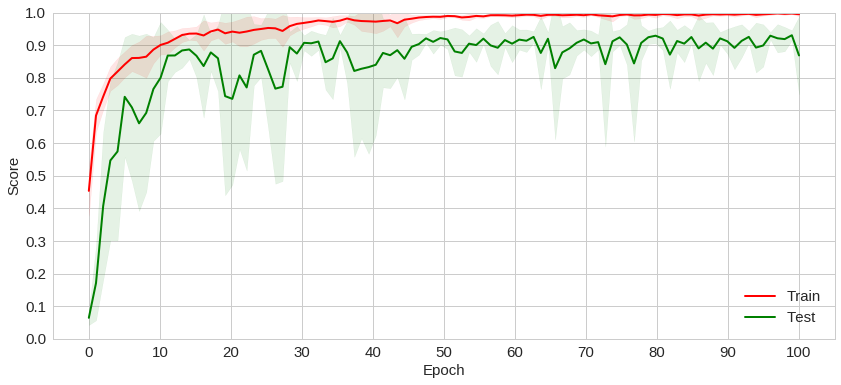

In [19]:
plot_mean_acc(history)

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

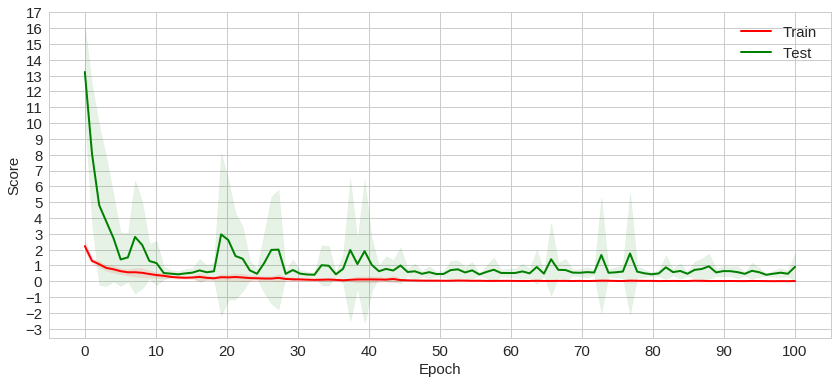

In [21]:
plot_mean_loss(history)

In [23]:
history = [{'acc': [0.66472783153574122, 0.79466637401229145, 0.82594381046462628, 0.84877085172889311, 0.91275241439859522, 0.92833625987708512, 0.93612818272099152, 0.94633450400316477, 0.95335820905988522, 0.95467515374820833, 0.94392010546023641, 0.96872256365232656, 0.97223441615452155, 0.96674714672450335, 0.9727831432126508, 0.97201492547779567, 0.98002633899842784, 0.98112379290536378, 0.98123353819139592, 0.97431957868236108, 0.97805092196594323, 0.97980684811237928, 0.98715978928884984, 0.99100087806778692, 0.98880597025391515, 0.98167251975417036, 0.97958735743565351, 0.98397717295873577, 0.98606233538191401, 0.98781826163301145, 0.98748902546093065, 0.98825724330044717, 0.98309920993784838, 0.98386742756804213, 0.99209833187006147, 0.99242756804214227, 0.99264705887586013, 0.98013608438912136, 0.98781826163301145, 0.98968393337946381, 0.98452589991220374, 0.9935250219490781, 0.99626865671641796, 0.99637840210711148, 0.989354697207383, 0.9834284460052678, 0.9854038630377524, 0.9925373134328358, 0.99659789299316004, 0.99648814749780512, 0.99802458296751539, 0.99396400351185255, 0.98024582967515361, 0.98891571553994728, 0.99736611062335379, 0.99539069369553057, 0.99056189650501258, 0.98946444249341525, 0.99374451283512666, 0.99857330992098337, 0.99945127304653203, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99989025460930636, 0.99056189640035119, 0.97563652337068418, 0.97552677787532927, 0.99473222124670768, 0.99879280070237053, 0.9993415276558385, 0.9996707638279192, 0.99989025460930636, 0.9993415276558385, 0.99978050921861283, 0.99989025460930636, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.99978050921861283, 0.99989025460930636, 0.97859964881474981, 0.96433274802458302, 0.9948419667420626, 0.99824407374890256, 0.9996707638279192, 0.99989025460930636, 0.9996707638279192, 0.99890254609306406, 0.99813432835820892, 0.98650131704934974, 0.98990342405618958, 0.99769534679543459, 0.99626865671641796, 0.99582967515364351, 0.99626865671641796, 0.99846356463495112, 0.99769534679543459, 0.99747585601404742, 0.9938542582258203], 'val_loss': [4.8753781914710999, 15.551443606615067, 15.318617641925812, 1.7573681306093931, 0.37937814322140184, 0.43300386318878736, 0.35174269472554442, 0.41048773867078125, 0.59519101000478258, 0.5321901773272657, 0.39643204740787041, 0.60897817269778898, 0.86069463781313971, 0.86506250538513996, 0.53742892153968569, 1.0007581971585751, 0.38366308830518392, 0.36778522736130981, 0.75965398865628231, 0.75571733393007889, 0.94787693148100516, 0.53340166816155943, 1.0619375600263083, 0.43506233779612558, 0.55000654223266565, 1.1587550409021787, 0.68164912978863867, 0.60110018677579546, 0.86744815134443343, 0.43037962828054788, 0.66609158236179766, 0.52552873465228345, 0.54624841361510335, 0.49362632510747062, 0.39455007401852527, 0.4398079013935785, 0.43658035730755529, 0.86067963644200063, 0.64896561056593782, 0.52687066786139169, 1.2657876714839631, 0.40428559506653983, 0.40819089576831402, 0.50270771922305357, 2.1366469796741683, 0.90517767182609532, 0.58286207601725692, 0.58728236249073262, 0.4799820546903284, 0.4834142483284154, 0.50791989244953584, 0.5657241534190689, 1.0117471119635866, 0.44007085250336786, 0.41499820120884579, 0.48903576154043549, 0.65489022603037661, 0.85598778416169807, 0.34849564244996323, 0.35977942648502825, 0.32977205807726051, 0.33089365972405815, 0.32781182210239024, 0.33063303699932334, 0.329689287014304, 8.1008970127440989, 1.4202119150431827, 0.74867652359853309, 0.36010144012269762, 0.33422205836109065, 0.36314717506839145, 0.36595334783994105, 0.36040170764174206, 0.39121856956545642, 0.37135481234626866, 0.37001008792271506, 0.36578157876923001, 0.37153240636996543, 0.36922207381772409, 0.37062308780173225, 0.36157055740583743, 2.9828988527879119, 0.87171862085233442, 0.35286015336441778, 0.36928493020339914, 0.30755868659859331, 0.3351826613972122, 0.36277937877909672, 0.33190848577013199, 1.2551873351309268, 1.3700612708086197, 0.41749440846751895, 0.36126894771834372, 0.44770329311127099, 0.39830559080519379, 0.36337826842429877, 0.41024874348522644, 0.40442899755612416, 0.46680455975047153, 0.50764856735531794], 'val_acc': [0.083984375, 0.03515625, 0.0341796875, 0.541015625, 0.892578125, 0.88671875, 0.90625, 0.9013671875, 0.8515625, 0.8837890625, 0.9072265625, 0.8564453125, 0.78125, 0.7763671875, 0.880859375, 0.705078125, 0.9130859375, 0.9267578125, 0.8271484375, 0.8037109375, 0.8173828125, 0.8876953125, 0.849609375, 0.912109375, 0.8955078125, 0.7138671875, 0.8515625, 0.8896484375, 0.826171875, 0.9013671875, 0.8876953125, 0.8818359375, 0.8779296875, 0.884765625, 0.9306640625, 0.91015625, 0.9267578125, 0.83203125, 0.8623046875, 0.89453125, 0.8291015625, 0.921875, 0.9189453125, 0.8984375, 0.6552734375, 0.8056640625, 0.892578125, 0.9013671875, 0.9189453125, 0.9111328125, 0.9296875, 0.8935546875, 0.826171875, 0.916015625, 0.931640625, 0.923828125, 0.875, 0.87109375, 0.9443359375, 0.9453125, 0.9482421875, 0.94921875, 0.94921875, 0.94921875, 0.951171875, 0.19921875, 0.681640625, 0.8369140625, 0.9404296875, 0.9375, 0.9384765625, 0.943359375, 0.9443359375, 0.94140625, 0.947265625, 0.94921875, 0.947265625, 0.94921875, 0.947265625, 0.9404296875, 0.9423828125, 0.57421875, 0.8291015625, 0.927734375, 0.931640625, 0.9384765625, 0.9404296875, 0.9404296875, 0.9384765625, 0.8212890625, 0.7275390625, 0.927734375, 0.93359375, 0.931640625, 0.9384765625, 0.94140625, 0.9384765625, 0.931640625, 0.923828125, 0.921875], 'loss': [1.322515829285579, 0.84502600822875751, 0.73298349937291607, 0.59327349371560523, 0.2927730080849042, 0.22313814455213205, 0.20131194617687556, 0.17240139041373978, 0.14738764181484559, 0.13747674839029822, 0.17999103864862587, 0.10076944780870421, 0.087093781449286645, 0.10268465869776296, 0.085956272553845497, 0.080039784662209651, 0.059217965967881252, 0.054963187897566435, 0.057720725793355486, 0.083081530186301059, 0.067456621001290587, 0.060877227035988468, 0.034811723447990252, 0.02911630422498334, 0.03464513424214849, 0.05853360800376723, 0.063928539044599039, 0.049244217608938413, 0.041889935486587752, 0.039882629225071423, 0.034319181288103962, 0.041157279100638662, 0.053275821928676512, 0.053723503282756477, 0.023328918126175432, 0.023288184526798341, 0.02188307555683474, 0.066886542608619676, 0.036090909054501207, 0.031658410833849258, 0.048756062276367036, 0.02040342399110499, 0.011015680334444916, 0.011719192155050989, 0.032161342629531596, 0.053947200918941382, 0.049694916703578826, 0.023415412390265282, 0.0092296910810421677, 0.011924151916303602, 0.0071231606691855775, 0.019537397254292328, 0.064426634159479607, 0.037741517788381827, 0.0084279457469412736, 0.016149872346700244, 0.029800025314702615, 0.036526286573279276, 0.018282132846923892, 0.0054183891997820824, 0.0022546981111768007, 0.0013409446886330015, 0.00081715157265470123, 0.00077776310368930822, 0.00065645223943227562, 0.034453439004888668, 0.084973318454882263, 0.08876801818883974, 0.018361608554217458, 0.0047041055329187544, 0.0027005345843165306, 0.0024962001153606434, 0.00094799321051988522, 0.0019044832041910957, 0.00072347208159274359, 0.00072385304370180638, 0.00064190310098146417, 0.00082240976209298862, 0.00065002778440360648, 0.0012699410231550492, 0.00069360024659206594, 0.080561385823065351, 0.11566763214564198, 0.01727874603103462, 0.0055192456761045143, 0.0022664938875667415, 0.0010718067086543364, 0.0011688604251173639, 0.0035145438158921643, 0.0051626085074943174, 0.0402872202834327, 0.03288089508894762, 0.0077958295808603605, 0.010745592443529526, 0.014403014251778022, 0.0097479733105167738, 0.0055096160560505767, 0.0078807222257066545, 0.0093443475771134051, 0.018060962707879508]},
{'acc': [0.46050032924240242, 0.66227781435154709, 0.70627605909837665, 0.81051130147782857, 0.83366249754472288, 0.84704849702735885, 0.86339697179654096, 0.8711871847605166, 0.81380294071416837, 0.83048057947238341, 0.86438446365900146, 0.86339697187501974, 0.89269256109152284, 0.90443274102138793, 0.91705069145351636, 0.89795918386966633, 0.91913539618548001, 0.92966864175484687, 0.93361860883845449, 0.94053105122168812, 0.94195742831566054, 0.94974764109651899, 0.94601711672022593, 0.94305464140752027, 0.95435593610587344, 0.96181698505465651, 0.96466973896792563, 0.95995172280765084, 0.96850998482213413, 0.97651964012718995, 0.97421549283178954, 0.97783629599176325, 0.9795918368262525, 0.97904323019530393, 0.98025016467352044, 0.98310291858678955, 0.98518762352802991, 0.97816545991539716, 0.98540706614378593, 0.99166118060127273, 0.98376124643405749, 0.98420013166556941, 0.9838709677419355, 0.99067368883037088, 0.99034452490673686, 0.9885889840722476, 0.98628483651525123, 0.98518762361958856, 0.98573623006741995, 0.9937458855425132, 0.99714724599517224, 0.98716260706983383, 0.97169190256747862, 0.98913759052007899, 0.98924731191951554, 0.99034452490673686, 0.99495281992917106, 0.99583059039219501, 0.98430985297344742, 0.98584595128373931, 0.98946675453527155, 0.9946236559139785, 0.99517226245336843, 0.99659863945578231, 0.99703752477885288, 0.99144173807707536, 0.98606539389949532, 0.99495281983761241, 0.99605003292947214, 0.99637919684002629, 0.99692780337941633, 0.99078341013824889, 0.99078341013824889, 0.99352644283519864, 0.99484309852973452, 0.99231950863165785, 0.99231950854009932, 0.99605003300795092, 0.9949528200207296, 0.99484309852973452, 0.99780557384244017, 0.99791529515031818, 0.99286811498793071, 0.99539170506912444, 0.9939653281582691, 0.98804037753285767, 0.98880842659644508, 0.99199034452490675, 0.99714724599517224, 0.99813473785763274, 0.99780557384244017, 0.99879306561334213, 0.99714724599517224, 0.99605003291639238, 0.99067368892192942, 0.99341672152732063, 0.9981347377660742, 0.9981347377660742, 0.9983541803818301, 0.99879306561334213], 'val_loss': [14.589673637643951, 5.239750455736881, 2.5777257487265333, 10.960075763806906, 2.0815303358586537, 0.55314719099741672, 0.53216905060220587, 9.9727216242810748, 4.8019025694367468, 2.588076126318855, 4.8816510347937419, 0.44604640577987215, 0.37284006321266905, 0.40047360887685374, 0.31171763327278912, 1.1097386749023881, 0.37608722224831581, 0.30812200472039514, 0.51629172345539531, 0.36550650227661818, 0.76877986545056654, 0.2983730398763792, 0.33226303067860247, 0.43332314433001662, 0.30131071645068458, 0.31457618473793897, 0.30934333136084685, 0.40473041103864837, 0.29172321506892102, 0.5894011500598626, 0.59982219221193067, 0.32324387755594614, 0.35633142651372979, 0.3482248897445166, 0.35788730682929115, 0.66053094598106921, 0.69954473468430733, 0.57357449512819458, 0.40003211882278494, 0.33940350030591698, 0.39498154050909062, 0.34287991120237715, 0.29100240623909224, 0.3625963031767217, 0.38331703294238073, 0.53832760474730257, 0.6412542972151225, 0.97097917378833043, 0.38374080642906511, 0.28851610111275872, 0.37389644538179106, 0.91020896360132331, 0.56197451403088428, 0.41467747857808746, 1.1761238791798108, 0.33381590124550076, 0.70723237904282366, 0.40463506608464778, 1.1272156070062029, 0.70055412725224697, 1.3224297682486155, 0.50096257748228079, 0.41345895072242889, 0.36924163196436377, 0.42510443342841181, 0.575056405601725, 0.72175861688771825, 0.31673680481200145, 0.46103852826130526, 0.48953606685801909, 0.45421983437923513, 0.92288947009022637, 0.45309081420066399, 0.37879246637421532, 0.38933322002817128, 0.72280160192657372, 0.42458183107536268, 0.47668003194080655, 0.58572501800109134, 0.39283933617523642, 0.421639038118584, 0.67004818802613109, 0.49924041214601939, 0.95704899395136223, 0.4366380640644687, 0.86999230981173825, 2.494737109326103, 0.41039464003935006, 0.39573789557422051, 0.35987919522700862, 0.42191979655159417, 0.3887527681284132, 0.43173625303467678, 0.43419297606294704, 0.53901519253473018, 0.51059766033600096, 0.33318944703656855, 0.34966596402000238, 0.35351039893987246, 0.34911519315797607], 'val_acc': [0.025440313111545987, 0.22015655565635098, 0.49119373671929195, 0.18199608581406729, 0.48336594806958549, 0.85127201145642428, 0.84148728007673046, 0.21624266106905068, 0.31702543833017816, 0.3610567512344241, 0.40313111452673744, 0.86497064322641448, 0.88845400824238874, 0.89823874405452186, 0.90802348173294511, 0.82387475281545564, 0.89334637708160047, 0.91585127038265157, 0.90606653177108321, 0.91095890235994192, 0.89530332424402703, 0.93052837130141586, 0.91585126851636134, 0.91487279493514806, 0.91878669112629152, 0.92172211093678635, 0.91682974303071985, 0.90117416386501659, 0.92563600339534935, 0.91193737325836299, 0.90802348161630198, 0.92954989865334769, 0.92172211000364124, 0.92954990051963793, 0.92661447697656263, 0.90900195251472304, 0.90215263931252021, 0.91976516190806945, 0.92857142682178151, 0.94129158069476226, 0.93052837223456097, 0.93639921372184076, 0.94227005964155996, 0.92661447884285286, 0.93346379472784802, 0.90900195531415851, 0.89823874498766698, 0.89041095983725471, 0.9354207410737726, 0.94911937471005314, 0.93346379297820092, 0.80821917364975249, 0.91193737815737486, 0.92563600526163958, 0.87964774916083377, 0.94227005520912066, 0.90704501118445346, 0.93737768905270125, 0.88356163940317711, 0.88160469783962125, 0.84833659397879224, 0.9236790571660678, 0.93248531846384242, 0.94031311247913341, 0.9197651647075048, 0.90900195344786816, 0.83170254239830721, 0.93835616263391453, 0.92270058451799963, 0.93346379391134604, 0.91976516377435968, 0.87769080304819547, 0.92172211000364124, 0.93346379297820092, 0.93346379391134604, 0.90606653200436948, 0.93444226562626909, 0.92759295149092102, 0.89236790256724197, 0.94227005427597554, 0.93052837223456097, 0.89726027245624196, 0.91878668926000129, 0.87964774787775923, 0.93150684674891937, 0.88845400940882013, 0.73679060642033412, 0.93346379391134604, 0.94129158162790738, 0.94227005427597554, 0.93639921372184076, 0.94031310711354887, 0.94422700330469245, 0.9344422683090613, 0.9138943222870799, 0.91487279691808143, 0.9442270014384021, 0.94129158337755447, 0.94324852785718882, 0.93933463353233559], 'loss': [2.1406323967310636, 1.3758040697710123, 1.325639821783555, 0.73277120936039852, 0.65021505956459336, 0.63446555185767939, 0.5339253607067278, 0.52693862940675473, 0.79770907264596047, 0.76406427130302579, 0.61757663318089073, 0.65564839751515858, 0.42365173854560007, 0.37361008113273436, 0.31581088714178962, 0.42466962491835525, 0.2792130427347978, 0.23394042642618287, 0.23417029657174496, 0.20017335738676903, 0.20494050201497005, 0.16456822392080916, 0.18438895038536093, 0.19080124198017032, 0.15123137008641566, 0.1220508864607653, 0.11307158270294478, 0.12555372229081799, 0.10111513366321474, 0.074052892689095901, 0.076127278613813978, 0.068141664218321851, 0.060850271609744037, 0.063154879283827861, 0.058086701398006209, 0.048885973107657507, 0.043910704463203672, 0.063667992731183926, 0.045385427262886642, 0.029565348023508256, 0.051661757078280905, 0.047555492337018952, 0.049149908668620949, 0.027775546303274393, 0.027982375473671016, 0.032473383553527232, 0.03917520679656105, 0.047165946993671909, 0.039955981793517684, 0.02115070037519249, 0.010711257266678162, 0.036462674138543115, 0.094286899973219596, 0.035288464770110155, 0.02831744689871233, 0.028774623719647133, 0.017092899427746559, 0.012983156809477441, 0.048847093183521914, 0.047325087314529238, 0.036770619522712329, 0.01777282473488143, 0.015717012072396102, 0.011464383613818099, 0.010665765526036807, 0.025934607184162808, 0.045552067659016218, 0.01470901987692989, 0.011318663601649711, 0.0125429685523299, 0.010201315241437655, 0.029182507143132527, 0.027998656151983426, 0.020574372571794734, 0.013806230223934672, 0.024723477108170647, 0.024080009656245637, 0.011893733638889119, 0.017553012860709601, 0.015902690371465356, 0.0080009550066433462, 0.006989305216630208, 0.021872648590080652, 0.013802890000445493, 0.0191529234677115, 0.03996822999131007, 0.037763149743505878, 0.024611641966797278, 0.00820554854907872, 0.0060818255985513759, 0.0062530672885744249, 0.0042488620617415285, 0.010131340405489598, 0.013208981541868087, 0.029115925642130589, 0.023000645480702787, 0.0054185699634924315, 0.0077348305252599343, 0.0045592157511052805, 0.0042832224351464915]},
{'acc': [0.42397981581325955, 0.71314172890689509, 0.75669153147802481, 0.82547169824397681, 0.8056164986211618, 0.817902589011684, 0.87318999576903378, 0.90193067145169747, 0.91531373425082396, 0.9289161913642866, 0.93483984214059612, 0.9425186486346725, 0.94306713470820536, 0.95250109707697173, 0.9553532252556507, 0.94997806065748946, 0.96160596768654139, 0.9652259763577048, 0.97180781054779231, 0.96851689337428692, 0.97520842480000403, 0.97268538832821416, 0.97827994739763457, 0.98189995617341341, 0.97882843352347526, 0.98705572619569992, 0.98091268100043882, 0.98233874511593211, 0.98222904785414855, 0.98025449769127626, 0.98760421237384821, 0.98727512071926693, 0.98760421242615593, 0.99023694602896006, 0.97981570864414214, 0.99067573497147876, 0.99681878016673975, 0.94306713481282078, 0.88405002214867801, 0.87691970162351907, 0.86627906984590342, 0.88788942539571614, 0.93374286973199183, 0.85179903471663421, 0.92474769638420562, 0.94942957437472575, 0.9640193067134708, 0.97378236068451074, 0.98047389211022784, 0.98332602018429138, 0.98606845107503294, 0.98716542353594494, 0.98266783682282111, 0.98913997367266349, 0.99188240461571275, 0.98771390966178552, 0.99330846862659061, 0.99517332163229488, 0.99506362439666518, 0.9894690654318602, 0.99111452396630506, 0.98705572624800764, 0.98881088196577449, 0.99297937697200933, 0.99254058797718292, 0.99605089956963988, 0.99539271610355418, 0.9947345327420839, 0.99385695485704662, 0.97827994734532686, 0.99243089079386104, 0.99012724879333036, 0.99605089951733217, 0.99681878016673975, 0.99780605528740673, 0.99594120228170246, 0.99791575252303644, 0.99539271626047732, 0.9863975428603835, 0.96950416849495391, 0.99703817463799915, 0.99868363322475173, 0.99868363317244402, 0.99901272487933301, 0.99923211935059242, 0.99934181658622201, 0.999670908293111, 0.99978060552874071, 0.99857393593681443, 0.98837209302325579, 0.98047389205792013, 0.98694602896007022, 0.99155331285651604, 0.99440544098288719, 0.99835454146555502, 0.99802544975866603, 0.99879333040807372, 0.99144361562088634, 0.99703817463799915, 0.99901272487933301], 'val_loss': [14.743316762587604, 3.8370651170319201, 2.0811041869369209, 0.76771262574429611, 7.9072021400227266, 0.81629908762726133, 0.42906289280337445, 0.56173130650730696, 0.34685418363295351, 0.33836378003744516, 0.35824577390563256, 0.34774978417976232, 0.33632094502156856, 0.29202118905434643, 1.2513488615260404, 0.29441629844071693, 0.39044692524361846, 0.49484623308275261, 0.41625302070477865, 0.35760338368149946, 0.4375027210396879, 0.32917260078590033, 0.32432062613832602, 0.31785515091774585, 0.42767788833383852, 0.92687461662948512, 0.33188548361455711, 0.37041836770698794, 0.36192770659653628, 0.46725444624944606, 0.38379339155941911, 0.37362003580018804, 0.4350196218811998, 0.57793758272777729, 0.3947309493160277, 0.38951006293697421, 0.32316823792712324, 15.475820803174786, 5.2761018075195016, 15.517617461260627, 5.9218094433055208, 1.5694029777073393, 0.49259923906887276, 2.6902384071409995, 0.32355947779381977, 0.30040243353224449, 0.31749908535435395, 0.33120248358794852, 0.35068795329014607, 0.33004729225472595, 0.35849520401006529, 0.37271316883018113, 0.37449643618733092, 0.35658913665615816, 0.35986559057389289, 0.43631912369792725, 0.38692607108857963, 0.37738094161479024, 0.43517502990262963, 0.39899029354137916, 0.3898812917476932, 0.39072050970874744, 0.40516457637446796, 0.40372470799198956, 0.3659646234356414, 0.39497379912223263, 0.38969955915436361, 0.3963173835593129, 0.44582550606197296, 0.38552857089575365, 0.40354845486404423, 0.39871508806079908, 0.46283979092187627, 0.38528736281367337, 0.41632107348817882, 0.40871213778474497, 0.4452184734035512, 0.44537687504890333, 0.40301343866666167, 0.36206002835305318, 0.33224833611897803, 0.33974593868982744, 0.3493475470182531, 0.35721444879996389, 0.35763359907034598, 0.36292060539169019, 0.35664362897410579, 0.359980379265744, 0.43150731711061335, 0.54560584130824963, 0.61704309413246261, 0.4320806037757482, 0.42395881669054847, 0.34464541657494097, 0.30857747151335119, 0.35313658460022007, 0.35927803753489285, 0.7285069101389644, 0.37773546760071636, 0.33877088288507223], 'val_acc': [0.085294117997674376, 0.19117647079276104, 0.54509804225435443, 0.80784313818987674, 0.11078431524482428, 0.8117647072848152, 0.87352941573834886, 0.83235294257893278, 0.91274510458403946, 0.89803921965991751, 0.90098039870168645, 0.9137254967409022, 0.91176471242717672, 0.92745098693698058, 0.84411764846128579, 0.9294117703157313, 0.91666666900410376, 0.92450980766146795, 0.91176471079097077, 0.92549020005207439, 0.90196078992357442, 0.9294117703157313, 0.9264705929101682, 0.9264705929101682, 0.90784314146228862, 0.88235294117647056, 0.92450981046639236, 0.92941176867952535, 0.93137255556443155, 0.90980392717847636, 0.92156863306082937, 0.93137255275950714, 0.90588235691481944, 0.880392162472594, 0.91372549416972138, 0.9294117703157313, 0.94117647362690349, 0.036274509803921572, 0.21568627509416319, 0.037254901960784313, 0.20000000046748742, 0.56960784687715416, 0.86372549159854062, 0.64803921802371156, 0.90980392554227041, 0.91960784711089794, 0.92156863048964854, 0.92549020168828033, 0.92647059478011784, 0.93039215990141322, 0.92058824183894139, 0.9264705929101682, 0.92647059478011784, 0.92156863048964854, 0.93039216247259404, 0.92745098343082499, 0.92647059478011784, 0.93235294678631953, 0.9254902026232551, 0.92450980789521164, 0.93431373110004501, 0.92647059478011784, 0.9235294157383489, 0.92450980696023677, 0.93333333637200144, 0.92647059384514308, 0.92843137815886856, 0.92745098436579987, 0.9254902026232551, 0.9235294157383489, 0.9147058837554034, 0.92352941737455485, 0.91666666993907853, 0.94117647362690349, 0.9294117703157313, 0.93921569188435872, 0.93333333894318227, 0.92647059478011784, 0.93039215990141322, 0.93333333987815703, 0.9411764761980842, 0.94509804482553517, 0.9411764761980842, 0.94411765266867242, 0.94313726051180968, 0.94705882913926065, 0.94509804482553517, 0.94607843698239791, 0.93235294678631953, 0.9166666706403096, 0.82647058963775633, 0.92450981046639236, 0.91862745238285437, 0.93823529879252121, 0.95000000560984887, 0.93823529972749597, 0.9441176536036473, 0.87941176797829423, 0.94215686741997218, 0.95294118114546233], 'loss': [2.3774786544191362, 1.1984970962964636, 1.0607483259362576, 0.81141882755610961, 0.87954657126958558, 0.74079058666195774, 0.47443644353934367, 0.31438167089822783, 0.2705337028327664, 0.23669047242405647, 0.21089856512926294, 0.18191410882946901, 0.17463713322045668, 0.14711904961872435, 0.15201719135974467, 0.1670150298620327, 0.11968792037333036, 0.10768442113522952, 0.081565467443786316, 0.093806834267832401, 0.082347746470966793, 0.086837301751620785, 0.072428657473467481, 0.054545147294614231, 0.063451122823561579, 0.046378051178033751, 0.066126868882334613, 0.062412840018752587, 0.050945983288344605, 0.064481310755629032, 0.042690919507654509, 0.036081583229739082, 0.037347474031251687, 0.034327088409569724, 0.057200192845090994, 0.032137484807470432, 0.010510991962512971, 0.31906216198961795, 0.66602884755421232, 0.6803071516917012, 0.69828691072974514, 0.59525723504936445, 0.33722301026926382, 0.74492727732020236, 0.23682733957000657, 0.14851931363553422, 0.10182269163488583, 0.077246143753563118, 0.059480776792100357, 0.052103951043756244, 0.042127294089120436, 0.040680125607451413, 0.049814005879691002, 0.033391109967261828, 0.025200178237005041, 0.034264699010380324, 0.022178237928799263, 0.016048158720027805, 0.017031942979694591, 0.032143597274498885, 0.027935290511758012, 0.03761749002247225, 0.030745910572565639, 0.02118900800087032, 0.02493485851030872, 0.015640486248766006, 0.01387614925167621, 0.016364104674737565, 0.020082571623645015, 0.065766681013068984, 0.024881996782623254, 0.03142955815096718, 0.013222888489562353, 0.0098058107887186718, 0.0075905064638142573, 0.013025345460778595, 0.0067036340280610474, 0.016454372503220571, 0.051527947940573117, 0.098365467562356132, 0.012321230717993924, 0.0042207046241727105, 0.0064067679387690953, 0.003460913900545046, 0.0033624512625134054, 0.0025027992358021955, 0.0015633034959869454, 0.001172485939555909, 0.004097356782599257, 0.03585896896593356, 0.068267927257176175, 0.039902845476870473, 0.027502305280562685, 0.022915830238247819, 0.0061259559750691389, 0.0067988253562163989, 0.0046874242946615885, 0.034555503629808394, 0.0094697596956847038, 0.0045812524326032042]},
{'acc': [0.37379385964912282, 0.64375000000000004, 0.69780701754385965, 0.73146929824561402, 0.75646929824561404, 0.79923245614035088, 0.79484649122807016, 0.77719298245614032, 0.82927631578947369, 0.83980263157894741, 0.86820175438596492, 0.88135964912280707, 0.88684210526315788, 0.91030701754385968, 0.91896929824561402, 0.92675438596491233, 0.93333333333333335, 0.93596491228070178, 0.94396929824561404, 0.94353070175438591, 0.94791666666666663, 0.95372807017543859, 0.96337719298245617, 0.95822368421052628, 0.9631578947368421, 0.96282894736842106, 0.95745614035087723, 0.97598684210526321, 0.98015350877192986, 0.97839912280701757, 0.97236842105263155, 0.97960526315789476, 0.98059210526315788, 0.97763157894736841, 0.98377192982456141, 0.97379385964912279, 0.96699561403508771, 0.98541666666666672, 0.9860745614035088, 0.98859649122807014, 0.987719298245614, 0.98157894736842111, 0.98486842105263162, 0.98673245614035088, 0.99035087719298243, 0.99122807017543857, 0.98410087719298245, 0.98519736842105265, 0.99067982456140347, 0.98782894736842108, 0.9826754385964912, 0.98190789473684215, 0.9922149122807018, 0.99473684210526314, 0.99111842105263159, 0.98782894736842108, 0.99451754385964908, 0.98179824561403506, 0.98903508771929827, 0.99714912280701751, 0.99802631578947365, 0.9994517543859649, 0.99835526315789469, 0.96732456140350875, 0.987719298245614, 0.99528508771929824, 0.99418859649122804, 0.99616228070175439, 0.99572368421052626, 0.99462719298245617, 0.99484649122807023, 0.99342105263157898, 0.99407894736842106, 0.99133771929824566, 0.99057017543859649, 0.99495614035087721, 0.98859649122807014, 0.99539473684210522, 0.9966008771929824, 0.99429824561403513, 0.99375000000000002, 0.99561403508771928, 0.98925438596491233, 0.99265350877192982, 0.99703947368421053, 0.99912280701754386, 0.99934210526315792, 0.98914473684210524, 0.98750000000000004, 0.9978070175438597, 0.99934210526315792, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.99978070175438594, 0.99978070175438594, 0.99967105263157896, 0.99978070175438594, 0.97817982456140351], 'val_loss': [12.96678915549451, 2.3089872891978014, 4.0891354590889035, 1.4498613472059956, 1.26053452773357, 6.240993574848325, 3.3109197391299752, 0.91640190252168907, 1.1732482938315925, 0.60426405702665353, 1.514486054023847, 0.45945119929653921, 0.49415208618926604, 0.42818467569075463, 0.70057382089577203, 0.65724756743202661, 0.41891320555252987, 0.38395098690537949, 0.47256874875303023, 0.51545393529007077, 0.39847045311773943, 0.46570565373287076, 0.76720288367430944, 0.48685376200556341, 0.43249417234242565, 0.36104073420198451, 0.43799253362580359, 0.39491285637340151, 0.49079127151477636, 2.014254401401272, 0.459699659480166, 0.47314047408422638, 0.69189690692097361, 1.1842450439270207, 0.68264784318290639, 0.6389834798824805, 3.3784587527588594, 0.62539283373836785, 2.4024532499818858, 0.50774445062077977, 0.53375620700229032, 0.88322601595702843, 2.571616813209546, 0.52921912064501397, 0.50102292724549202, 0.70271736667979257, 0.56719280751105805, 0.50656097808499856, 0.81925224098842131, 0.90407044363927003, 0.91672285586800961, 2.3903999066376329, 0.85784727054112775, 0.50753798079264523, 2.1074458929451731, 0.52791138360514578, 1.6979660605460618, 2.9727671759159078, 0.61664354355832174, 0.43145930815636457, 0.50056751348403405, 0.44479820404432585, 0.50067168834411002, 0.98240961972257401, 0.65645732504271015, 2.2819873156641703, 0.60658140509880787, 0.57006537169355742, 0.98443099134464329, 1.1784652258511503, 0.57070911436100624, 0.67688994859538509, 0.55716617635930665, 1.0519326855575182, 0.56856949161894454, 1.0354178242209489, 0.53000797271478384, 0.53472718631668859, 0.57392392244385315, 0.71674385479116243, 0.77476227179529167, 0.96959200925441225, 0.75325469087177377, 2.0636730667452432, 0.56513124769856127, 0.57774351402840207, 0.5186155688503844, 2.9682166543964912, 0.54400772383890461, 0.44438982972283031, 0.52843486124714134, 0.46345970157819544, 0.45548155023942583, 0.45159046088107746, 0.46592025142054239, 0.46930669418275833, 0.46779262779122432, 0.45701589054109859, 0.47332714166102829, 2.8463431460650903], 'val_acc': [0.045275590551181105, 0.37598425290715975, 0.3375984251968504, 0.61220472534810466, 0.66141732611994108, 0.29527559055118108, 0.36515748031496065, 0.72834645857022506, 0.67421259701721314, 0.81889763779527558, 0.74803149887895959, 0.88188976471818337, 0.85433070866141736, 0.88976378140487067, 0.8395669281952024, 0.84251968503937003, 0.89173228393389481, 0.8996063001512542, 0.87303149700164795, 0.88582677165354329, 0.89862204818275027, 0.89960629968192629, 0.78346456786778973, 0.89763779527559051, 0.89763779574491842, 0.9163385831464933, 0.90452755952444597, 0.91240157527247756, 0.90649606393078186, 0.74803149794030377, 0.90649606111481429, 0.90452755905511806, 0.85137795416388928, 0.74212598519062434, 0.85925196897326495, 0.88976377999688694, 0.65452755858579015, 0.89468503749276707, 0.72637795463321719, 0.89271653590239874, 0.88484252015436726, 0.85236220800970486, 0.69685039323145948, 0.90944881889763785, 0.92125984251968507, 0.89173228393389481, 0.888779528028383, 0.91929134421461212, 0.85433070960007318, 0.86909448725032057, 0.83267716347701903, 0.6889763779527559, 0.83759842613550617, 0.90944881936696575, 0.76279527512122325, 0.91535433117798937, 0.71850393747720198, 0.65551181149295001, 0.87696850393700787, 0.91535433352462892, 0.91535433352462892, 0.93208661698919582, 0.92322834739534876, 0.83464566976066645, 0.8927165335557592, 0.72933070772276154, 0.88188976284087173, 0.90551181149295001, 0.80708661980516327, 0.82874015794964284, 0.888779528028383, 0.86712598425196852, 0.9143700824947808, 0.84153543119355445, 0.91830708708350117, 0.82578740251345895, 0.90354330755594203, 0.92027559102050904, 0.91240157574180547, 0.8661417332221204, 0.82480315242226665, 0.86318898013257606, 0.8789370059967041, 0.74311023809778409, 0.91535433117798937, 0.91929133905200511, 0.9261811051781722, 0.66240157292583801, 0.89271653637172665, 0.93011811305218794, 0.92421259889452478, 0.92814960911518007, 0.93208661698919582, 0.93110236502069188, 0.92814960629921262, 0.92519685039370081, 0.9301181107055484, 0.93011811305218794, 0.91929134421461212, 0.63582677400018284], 'loss': [2.4933784426304331, 1.3721546997103775, 1.2848107452978168, 1.1863007097913507, 1.0142656849141707, 0.82659718791643777, 0.85835949349821661, 0.98685079216957095, 0.72449242775900324, 0.67317598869926054, 0.51512537117589985, 0.39532623500154729, 0.37229393443517517, 0.29029008317411992, 0.25694213721312975, 0.23300181810270276, 0.20879924914293121, 0.19539238193578887, 0.17912613556050419, 0.17828759020357801, 0.16142852484134207, 0.14303271923410266, 0.11540665009565521, 0.12386763830456818, 0.11541335012829095, 0.1136949121821345, 0.12500333976850175, 0.076355711228557319, 0.05799665793515088, 0.069474571335472565, 0.084472040551012026, 0.061573787353802145, 0.057487920777904884, 0.064595964472544815, 0.047091623993688506, 0.080422410734912811, 0.10264261307586965, 0.043050228355027607, 0.044986838376835772, 0.030441664874741578, 0.034696486796121716, 0.057301197540864608, 0.042017777021484154, 0.041180275231926584, 0.029147878505714368, 0.026333394283102007, 0.047005285621057019, 0.044375201924949099, 0.029903300841780084, 0.035201201422891598, 0.048891153882600756, 0.055017086023693547, 0.023725287421001939, 0.01389928249348151, 0.02676740908084372, 0.03626998182827313, 0.018924093109212423, 0.05579012925736606, 0.033594800840058413, 0.009142456209621997, 0.0075713400464513126, 0.0037729590606575491, 0.0063078765909283484, 0.1101475739900611, 0.038396619798680934, 0.018491653356243642, 0.01645254952191751, 0.012024893011339213, 0.015711124396215095, 0.018207145238697545, 0.01899946385855672, 0.02135800486410102, 0.018124476284924241, 0.031367780884376549, 0.026327291442890113, 0.016272830990706817, 0.035383362999480021, 0.014782009588190958, 0.011521796331171093, 0.017652434202752549, 0.019824217150004157, 0.012115756685134808, 0.031162757412612176, 0.02056269470210138, 0.010425537365556107, 0.0042766453758910456, 0.0032443773790107929, 0.037246657143425593, 0.038114872001103341, 0.007405153448308467, 0.0029412517909740768, 0.0013082406186616649, 0.0011856875330945433, 0.0011056136939084369, 0.00099297781509863976, 0.00085518091307261652, 0.00094713667388356972, 0.00090695360025149472, 0.00096008369631849823, 0.077061350626191641]},
{'acc': [0.42390350877192984, 0.66195175438596487, 0.74879385964912282, 0.78552631578947374, 0.77039473684210524, 0.77993421052631584, 0.79747807017543859, 0.82072368421052633, 0.87653508771929822, 0.88640350877192986, 0.89605263157894732, 0.90482456140350875, 0.91820175438596496, 0.92872807017543857, 0.92850877192982462, 0.92335526315789473, 0.80328947368421055, 0.87620614035087718, 0.8928728070175439, 0.89967105263157898, 0.9084429824561403, 0.84353070175438594, 0.83278508771929827, 0.85263157894736841, 0.89813596491228065, 0.92554824561403504, 0.93256578947368418, 0.94539473684210529, 0.94890350877192986, 0.9514254385964912, 0.96063596491228065, 0.95997807017543857, 0.96721491228070178, 0.97412280701754383, 0.97313596491228072, 0.97807017543859653, 0.97905701754385965, 0.97960526315789476, 0.97916666666666663, 0.97982456140350882, 0.98421052631578942, 0.98925438596491233, 0.98234649122807016, 0.98081140350877194, 0.98256578947368423, 0.98750000000000004, 0.98991228070175441, 0.98870614035087723, 0.98135964912280704, 0.98596491228070171, 0.98815789473684212, 0.99287280701754388, 0.99396929824561409, 0.99396929824561409, 0.99232456140350878, 0.99177631578947367, 0.98640350877192984, 0.9922149122807018, 0.99682017543859647, 0.99714912280701751, 0.98234649122807016, 0.99057017543859649, 0.98629385964912286, 0.99473684210526314, 0.99035087719298243, 0.99407894736842106, 0.99671052631578949, 0.99835526315789469, 0.99824561403508771, 0.99155701754385961, 0.99396929824561409, 0.98114035087719298, 0.98782894736842108, 0.99418859649122804, 0.99243421052631575, 0.99254385964912284, 0.99561403508771928, 0.99353070175438596, 0.99451754385964908, 0.99671052631578949, 0.99835526315789469, 0.99890350877192979, 0.99868421052631584, 0.99802631578947365, 0.98793859649122806, 0.9821271929824561, 0.99791666666666667, 0.99901315789473688, 0.99901315789473688, 0.99879385964912282, 0.99934210526315792, 0.99934210526315792, 0.99539473684210522, 0.98015350877192986, 0.98925438596491233, 0.99758771929824563, 0.99879385964912282, 0.99923245614035083, 0.99824561403508771, 0.99692982456140355], 'val_loss': [14.753768432797409, 11.788562098826011, 14.083084902425451, 5.2376417024867745, 8.2140648571525041, 1.8132724008691592, 5.2096654448922228, 0.50918542507185238, 0.39572517808497421, 3.8428903027312962, 0.33952991171890329, 0.35244627199575718, 0.30999720520449903, 0.32612797129300231, 0.29775159559065961, 0.29813944792565633, 2.853568705048148, 0.77127293104261863, 0.38301168355768123, 0.46437697083227275, 3.0725752969426434, 9.5475726653271771, 6.9173380483792526, 2.0659341551656798, 0.33153542808640207, 0.33006783258157857, 0.31319653827423877, 0.29869436548553469, 0.3493132508362084, 0.3131395611214437, 0.31450799145684466, 0.30695917535441247, 0.3417256678701846, 0.47309452137226005, 0.31242392798789453, 0.36948494541396454, 0.33585613838252137, 0.35997166077064452, 0.35481312094686196, 0.40325847996307601, 0.34936309689358558, 0.40615081658055657, 0.39296888356238208, 0.47124816890069149, 0.35114692454191943, 0.42365689701437365, 0.42712600741273987, 0.4066746594326105, 1.6578808370538434, 0.43074438270042359, 0.38401519542896395, 0.42394303467113792, 0.41624665701960289, 0.43830275448272005, 0.39725136366768143, 0.4978628022262595, 0.48667993959739891, 0.4106300851266797, 0.38380236951957697, 0.53578022333585695, 0.77720927536408746, 2.0633935477793943, 0.36045799295870679, 0.3570465777439677, 0.52343235035816471, 0.39983622753611525, 0.37509190901201106, 0.38971327877120943, 0.45348816655384477, 0.40217283187775849, 1.4974411530053531, 0.47458644743686118, 0.54733156689063811, 0.43490566741474046, 0.47417222346017857, 0.37979447039937242, 0.47496100960531268, 0.45059809096991249, 0.42690103950094166, 0.39196592517353968, 0.43549183394354823, 0.45537348266170347, 0.47583706506828805, 0.56905489632727824, 0.74944643570498859, 0.5073230719043943, 0.41610526221903837, 0.42773902607286873, 0.40977644648538036, 0.43770408724566279, 0.47611542569194354, 0.48966984642214989, 0.82000895997318701, 2.1278881444705755, 0.52418326780082847, 0.37141498715220855, 0.34000086472986274, 0.39510879788783193, 0.49856694984015931, 0.53048172890571832], 'val_acc': [0.084645669408670562, 0.17322834739534873, 0.076771653660639066, 0.22145669572935331, 0.024606299256597918, 0.52559055118110232, 0.20964567210730606, 0.84940944881889768, 0.88484251874638353, 0.67224409730415646, 0.90944881889763785, 0.89960630202856584, 0.9114173218959899, 0.90551181102362199, 0.9350393719560518, 0.90748031402197404, 0.37696850487566369, 0.76771653918769411, 0.8868110273766705, 0.88090551181102361, 0.63090551181102361, 0.14763779762223012, 0.37795275966013508, 0.69783464707727505, 0.90551181383958956, 0.90944881889763785, 0.91240157761911711, 0.92618110611682802, 0.9232283492726604, 0.91633858549313285, 0.92125984627430835, 0.93208661698919582, 0.91141732283464572, 0.90452755811646224, 0.92716535714667614, 0.91437008343343662, 0.9261811051781722, 0.9232283492726604, 0.92322834551803712, 0.92519685133235663, 0.92125984251968507, 0.92224409824281228, 0.92913385826771655, 0.91437007874015752, 0.92618110611682802, 0.91437008155612498, 0.92421259748654105, 0.92814961005383589, 0.82578740298278686, 0.9232283492726604, 0.9232283492726604, 0.92618110611682802, 0.93110236502069188, 0.92027559055118113, 0.92027559336714859, 0.9261811051781722, 0.91141732565061317, 0.93011811305218794, 0.93110236220472442, 0.90846456974510137, 0.87204724597179983, 0.81889763967258722, 0.93503937007874016, 0.93700787777037131, 0.89566929039992682, 0.93405512186485951, 0.93996062992125984, 0.93503937007874016, 0.92618110236220474, 0.93307086895769975, 0.80216535480003659, 0.91929134045998884, 0.90649606440010977, 0.92913386108368401, 0.9360236220472441, 0.92618110611682802, 0.92519685414832409, 0.93011811023622049, 0.93110236220472442, 0.93503937007874016, 0.93011811305218794, 0.9360236220472441, 0.92814960629921262, 0.91338582677165359, 0.87204724784911147, 0.92421260217982015, 0.93996062992125984, 0.93996062992125984, 0.93996062992125984, 0.93799212598425197, 0.93307086989635557, 0.93110236502069188, 0.87598425102984812, 0.69291338535744373, 0.90551181008496617, 0.93897638076872336, 0.94488189257974697, 0.94192913385826771, 0.92814960723786843, 0.92814961005383589], 'loss': [2.3814115574485379, 1.4687497548889696, 1.068227640160343, 0.9218413465901425, 1.0187326889289052, 0.88606534757112199, 0.83435768286387124, 0.72331694950137226, 0.46480531284683629, 0.41416457718924471, 0.33780053038346142, 0.32082235818369348, 0.26208052258742481, 0.23351538424429141, 0.2302566966989584, 0.35316151602749241, 0.96685460973204229, 0.62481908850502554, 0.43809236638378679, 0.40169556187955957, 0.39856666585332468, 0.73075578400963226, 0.746557529139937, 0.55740889781399772, 0.34181580020670305, 0.23425736280909756, 0.19544524913817121, 0.16697652708542973, 0.14790745479495901, 0.14294758073070593, 0.12091664971228232, 0.1135962720306819, 0.097324641937749423, 0.085751151571279036, 0.078453053217054453, 0.067065231443235743, 0.060660229734422866, 0.057819892100074835, 0.063971181253069331, 0.055513863157677021, 0.048171068726336225, 0.036414383779884429, 0.053437362057401946, 0.051674604561310587, 0.051988304774848774, 0.039325669873505831, 0.031121460037109885, 0.033355681696220447, 0.059146147557093125, 0.038089569004481301, 0.037355282068612022, 0.023363651443076762, 0.021200289018860643, 0.019488822468638159, 0.023689990603822497, 0.023397466349578872, 0.042073900486228236, 0.024749897995947352, 0.012919702499046955, 0.010856063945398649, 0.051446246945201175, 0.030904880033707931, 0.039593376300150626, 0.017358458313372051, 0.026547466547702226, 0.019166548236011806, 0.011345352565567417, 0.005180665865242318, 0.0063006831583232014, 0.025935267749765331, 0.018182826227010146, 0.058013423341081331, 0.037247378890516991, 0.015823429468416673, 0.024863977611612267, 0.022244265001969771, 0.015721463324837062, 0.020119840306589348, 0.018320362634850634, 0.010374664723068442, 0.0055012564494462454, 0.0045015717539762705, 0.004549507830795432, 0.0049850570680287651, 0.041954252648110126, 0.053495071661707604, 0.010587055115141547, 0.0036535103052237742, 0.0029580487401976267, 0.0035262552885493887, 0.0027257078820727195, 0.0030324424517937333, 0.014757170111248311, 0.0620749809321735, 0.035031196701732513, 0.0096391548552721938, 0.0052298728278082421, 0.0033271527179749684, 0.0047712389658523821, 0.0094969711434953891]},
{'acc': [0.42947945216257277, 0.65578082199619236, 0.74246575357489386, 0.80799999997387195, 0.81698630152009943, 0.83386301389459061, 0.85402739771751512, 0.80087671254432369, 0.84668493176812998, 0.87320547947165084, 0.88876712374491229, 0.90082191795845556, 0.90750684938038861, 0.91846575350957371, 0.92427397286402035, 0.92712328780187314, 0.92723287679724498, 0.9357808219178082, 0.94421917814751199, 0.95495890417490925, 0.95616438375760426, 0.95967123294203249, 0.96383561663431661, 0.97117808232242109, 0.97073972609271741, 0.97238356177447594, 0.9641643835616438, 0.97424657547310611, 0.97676712328767124, 0.98630136992833384, 0.97808219184614209, 0.97271232876712332, 0.98652054801052569, 0.98279452061326533, 0.96679452061326532, 0.96427397273338, 0.9806027397913476, 0.96515068499682699, 0.98082191787353934, 0.98564383568175851, 0.99178082204844853, 0.99331506849315065, 0.95210958917173616, 0.92284931532977377, 0.95835616427251735, 0.97106849315068489, 0.98268493150684932, 0.98476712335299144, 0.98684931519913344, 0.98849315075025168, 0.98761643848680469, 0.99397260273972599, 0.99419178088723792, 0.99287671239408726, 0.98630136986301364, 0.99276712335299144, 0.99408219178082191, 0.99430136986301365, 0.99539726027397257, 0.99167123294203252, 0.99079452061326534, 0.99002739714922972, 0.98794520547945208, 0.99473972602739724, 0.99791780821917808, 0.99868493150684934, 0.99824657534246575, 0.99254794546676006, 0.98279452061326533, 0.99419178088723792, 0.99594520547945209, 0.99627397260273975, 0.99320547945205484, 0.99419178082191784, 0.99178082191780825, 0.99353424657534251, 0.96120547958269509, 0.96613698636668999, 0.98520547945205483, 0.98531506849315065, 0.98586301369863016, 0.99298630150050338, 0.99517808225710103, 0.99747945205479449, 0.99824657534246575, 0.95539726046993312, 0.96569863013698631, 0.99002739714922972, 0.99068493157216952, 0.99715068499682702, 0.99682191780821916, 0.99835616438356167, 0.99846575348997768, 0.9766575343772157, 0.99123287671232874, 0.99430136986301365, 0.99616438356164383, 0.99397260273972599, 0.99539726033929277, 0.99627397260273975], 'val_loss': [14.476176304497658, 8.2497987472456824, 1.2427915245677785, 0.59425093424455822, 1.6820457962394115, 0.55158460435008905, 0.6039260702371656, 2.7097020644462426, 0.88623203093998515, 0.41621118315986544, 0.61158048133821796, 0.34449978422237199, 0.29355581065696967, 0.30219322894759748, 0.36610208282251905, 0.36591154364841361, 0.63348742616643827, 0.38705608676695269, 0.35889625037687761, 0.41650479777718863, 0.43404139873860026, 0.52646817192969553, 0.32023481802110265, 0.39658271181963672, 0.3158068161689917, 0.35640723030170396, 0.41179560952292271, 1.0090337950832089, 0.48411564183098788, 0.36122258203555524, 1.0285076610025472, 0.41989241013760598, 0.40821798765553075, 0.50489611449834737, 4.2546264448458313, 0.54991686005151519, 1.3174137543116786, 0.35808350243278653, 0.33828090925197735, 0.31053249897830498, 0.35497566933249158, 0.522274166611158, 2.2269067910935592, 0.65094005935903709, 4.0172624359262921, 0.98380458743691912, 2.0503641290315651, 0.36103140576130088, 0.39919866153484151, 0.39935264088173, 0.36006092147175844, 0.36759807575566916, 0.45646251076289002, 0.5890428830775688, 0.36596159983963478, 0.37074595915925762, 0.34218690711706756, 0.40438075311312632, 0.39325507987631964, 0.41026571885204632, 0.37975971542324588, 0.49795525734018975, 0.34862314229360719, 1.1548101516399683, 0.39024020899752249, 0.42446289571097928, 0.47239366899547963, 0.57301909943745943, 0.44059690488141084, 0.45138149175670417, 0.38482692480973185, 0.5097486885118534, 0.4418978399254444, 0.52489346370071499, 0.45967424344116836, 0.40789560467133973, 13.297600396191212, 1.5947828351250148, 0.32447358992382747, 0.60120234857787747, 0.47508154970833522, 0.8420438567361721, 0.41853346641089956, 0.39654359307314108, 0.4188762985718551, 1.9042290591816284, 1.2987232013620753, 1.0309398200036608, 0.95135573728164913, 0.43523753098122225, 0.46683210866161068, 0.43759937698996237, 0.53728354935516975, 0.53457913210512842, 0.44128320872614524, 0.48756591818672274, 0.40179944460549405, 0.4062134402231759, 0.39618600941570448, 0.36027324812104966], 'val_acc': [0.051434226606767088, 0.090009894970026968, 0.58259149675435296, 0.81602374199707828, 0.72799209022616307, 0.8387734953656748, 0.81800198130508561, 0.53115727011073821, 0.84272997174135655, 0.87537092300598041, 0.86449060477795403, 0.90603363319391317, 0.91592483002873015, 0.91691394965325568, 0.89812067566710341, 0.88822947889124249, 0.87339268464127118, 0.90306627414346807, 0.91493571028629228, 0.90900099218540209, 0.92680514342235409, 0.89020771513353114, 0.92185954807066417, 0.92878338585503617, 0.93273986464791903, 0.9228486646884273, 0.92977250247279919, 0.88328388041487782, 0.9030662740845119, 0.91889218907917525, 0.85163205072033177, 0.92878338585503617, 0.92581602680459107, 0.89020771825820588, 0.51928783468275708, 0.87042532452961574, 0.73095944915869593, 0.92581602680459107, 0.93175074490548127, 0.93175074496443733, 0.94460930079074334, 0.90999011192783996, 0.6488625154886708, 0.84866469155197444, 0.57270029844563275, 0.83481701592427449, 0.81602374199707828, 0.93570722363940806, 0.93372898120672598, 0.93175074183976259, 0.93175074490548127, 0.93867458274880922, 0.93175074496443733, 0.87537091988130566, 0.93570722363940806, 0.93669634338184582, 0.93768546300637146, 0.92581602680459107, 0.93867457962413448, 0.92185954807066417, 0.93768546306532752, 0.91097923167027772, 0.92977250247279919, 0.8229475797224941, 0.94164194174029825, 0.93768546300637146, 0.92878338585503617, 0.91196835129480336, 0.93966370237333485, 0.92581602686354714, 0.93471810395592636, 0.91790306933673738, 0.93273986458896296, 0.90900099218540209, 0.92977250559747393, 0.92779426617155447, 0.12660731948565776, 0.75667656151878138, 0.93471810401488242, 0.91394659113341581, 0.9297725056564301, 0.87734916231398763, 0.94263106142377995, 0.94164193867457957, 0.94460930079074334, 0.59841740992137638, 0.8793274017399072, 0.89416419699213268, 0.91196835123584719, 0.94658754015770674, 0.94263106142377995, 0.94559842047422504, 0.93372898427244466, 0.90801187285565721, 0.9347181040738386, 0.91889218907917525, 0.94757665990014461, 0.94658754015770674, 0.94164194174029825, 0.94955489920815184], 'loss': [2.408292783893951, 1.3537218763534338, 1.0354942801619229, 0.78395527582952418, 0.81356404338470878, 0.7169818645176822, 0.68943175814249746, 0.90220189297035946, 0.62434616441596047, 0.4884204995338231, 0.39603536586892113, 0.32499992072745543, 0.29549252246095709, 0.26777166806835018, 0.24708782005473359, 0.22815222217448769, 0.28412107190693897, 0.2128103165218275, 0.17952468305377112, 0.14223767131567, 0.13487309466649408, 0.12948614049611026, 0.11404193445101177, 0.095576012421960704, 0.090007208350586565, 0.088989626897524488, 0.10846779682946532, 0.088051069135535259, 0.067879097813612788, 0.041561350330098036, 0.098862534692026161, 0.08168969128985111, 0.038872536476344276, 0.050962965742365952, 0.12281064698794117, 0.13649624786964834, 0.060040701428913087, 0.1294584729524508, 0.059897445016527828, 0.051543151176547349, 0.027101482899629905, 0.020659057240882149, 0.31392068345987634, 0.36185545101557692, 0.20392457776526882, 0.083217785104700959, 0.055793024057828607, 0.052626880284858076, 0.044884844855902946, 0.044180209525643964, 0.043974474222692725, 0.022622122690796036, 0.020867845695516835, 0.030796960587370886, 0.045307404539968871, 0.028569770521905326, 0.021137268573249855, 0.022217881086142095, 0.019766052501862995, 0.029880515887720945, 0.029559476010195197, 0.027624138880265901, 0.040007796111988694, 0.018265364574402417, 0.0088931449001068124, 0.0041036133322705694, 0.0059605989727376614, 0.024193073882121746, 0.05111376980763592, 0.019285544995167485, 0.012277672897973289, 0.011804958657654997, 0.021290852315417708, 0.017833188275615239, 0.028552510353672789, 0.024193690066774413, 0.26281699404161268, 0.18366425426365579, 0.11967172744094509, 0.088907971094324162, 0.055924437567489604, 0.02627599891550737, 0.017929537083698464, 0.012705402307059259, 0.010268054109321882, 0.22263841988942396, 0.21503105807549333, 0.038734459305871022, 0.030455692524371081, 0.012243810349641598, 0.013708688027327498, 0.011720977696577367, 0.012346908075122596, 0.075881773896413304, 0.028638755844268081, 0.021573804451280262, 0.016500087752530021, 0.019736639065999692, 0.020427115135405162, 0.013978444365963136]},
{'acc': [0.48548263404120406, 0.74504218260717114, 0.6952996604137226, 0.79423687962068845, 0.82655856257215365, 0.85121069357927281, 0.86611153722997958, 0.83389941941637769, 0.71699353571566093, 0.83116029367345545, 0.86293415147111174, 0.8795880355317216, 0.89941930540344395, 0.91180015345634347, 0.91552536432983656, 0.92034622550441703, 0.93437054893384563, 0.93831488991980094, 0.93053577300738677, 0.90621233702855319, 0.91015667800797784, 0.9074175523564838, 0.93437054895343741, 0.95091486798067326, 0.95847485485899231, 0.96461049634263274, 0.96658266681928395, 0.96833570725530949, 0.97644351924172335, 0.97370439356410698, 0.97600525913434966, 0.98016873014786943, 0.98290785581895523, 0.95672181440337511, 0.97512873891307161, 0.98729045689922312, 0.98794784704722249, 0.99112523282568199, 0.9910156678053692, 0.98422263614107641, 0.98553741645666704, 0.98586611153719728, 0.99013914758409116, 0.99178262299327324, 0.98378437603370272, 0.98772871700006626, 0.99550783389941933, 0.99528870384573243, 0.99145392791927356, 0.97512873890654106, 0.99013914758409116, 0.98597567657057139, 0.98608524159088418, 0.99506957379204553, 0.99616522406701047, 0.99079653774515175, 0.99002958255724771, 0.99309740330886376, 0.98805741207406594, 0.98871480223512653, 0.99485044373835874, 0.99331653337561188, 0.99013914759062172, 0.99254957818117728, 0.99244001314780317, 0.99474087871151529, 0.99506957379204553, 0.99583652897994956, 0.9943026186172027, 0.98904349731565688, 0.99506957379204553, 0.99627478908732336, 0.99342609838939411, 0.99101566779883865, 0.99627478908732336, 0.99748000438913165, 0.9941930535838287, 0.99046784267115207, 0.99769913443628788, 0.99769913443628788, 0.99496000877173274, 0.99452174865782839, 0.99276870822833352, 0.9966034841678536, 0.99967130491946965, 0.99934260983893941, 0.99923304481209596, 0.99835652460387914, 0.99002958256377827, 0.99298783828202042, 0.99200175304696003, 0.99320696833570721, 0.99583652897994956, 0.99857565465756593, 0.99945217486578286, 0.99956173989262631, 0.99605565903363646, 0.99035827764430862, 0.99627478908732336, 0.99901391475840906], 'val_loss': [14.095116137985668, 7.8139754957911753, 3.7128110835467152, 1.4587746270229842, 1.4519891724557172, 0.8733984108264784, 0.52598890753387229, 9.5975630318799503, 8.5849308168923528, 1.4261149879844031, 0.49796227106653296, 0.33053484133733629, 0.35336539714908222, 0.33695903703629437, 0.29981275151469405, 0.37607180604635487, 0.31923893618704779, 0.3995636318864742, 2.249328574482873, 10.811793593868865, 6.6503451038281201, 0.93653408650999259, 0.30361287382304875, 0.26458331144325886, 0.31697926454488795, 0.53042479355637684, 0.27856733748177942, 0.37304611937497117, 0.43700114222740932, 0.30799037932323486, 0.34892774151073352, 0.92215269855597415, 0.31126212103315304, 0.76177697369276853, 0.30627236777696876, 0.30696412214062996, 0.35730971029624564, 0.34850535688362116, 0.45530864844849128, 0.38721203172471647, 0.49567367081097496, 0.46411173467782102, 0.30278452844089865, 0.47179891524818651, 0.33873828346290691, 0.38104527225169632, 0.37505556266557338, 0.52634595503453241, 0.40311680791938509, 0.41700111270920237, 0.63509121249664735, 0.66628517274471599, 0.50993484042319992, 0.32716539255721094, 0.39957940973488226, 0.41382123832660106, 0.65507513618361957, 0.46850926897555917, 0.6876955972232176, 1.2669096768079593, 0.34789170654157564, 0.66870846215276958, 0.41178237555081065, 0.58008650606876555, 0.65460269879715882, 0.39559052786018145, 0.62659068730685397, 0.49177416350565134, 0.89721767920392248, 0.49243576515587584, 0.33369743716528633, 0.5508951460585606, 0.36258387208684167, 0.9945898257151875, 0.91337514045690016, 0.34787969212303893, 0.60155114423724876, 0.95179585352090279, 0.50340648030362123, 0.35018126949957845, 0.48378121017882181, 1.1599821607019001, 0.54496444766414309, 0.53372873633185047, 0.32774258367399473, 0.3582987146774364, 0.36785930268211903, 1.051682681039148, 0.60158950358452012, 1.1117543999223491, 0.51844358068465823, 1.7194740683720904, 0.46092538063409089, 0.42069641695080462, 0.31579720019124902, 0.35219757318694805, 0.99596247038591856, 1.3552769785830003, 0.34798593912666015, 0.34709123876642684], 'val_acc': [0.046580773042616451, 0.10505450941526263, 0.26065410861175053, 0.74231912719955295, 0.72943508394645862, 0.84241823463657328, 0.86719524127877035, 0.11892963288678642, 0.35381565968865092, 0.78889989888349066, 0.87215064178018786, 0.8999008880734326, 0.890981167052735, 0.91674925426779941, 0.90882061204777953, 0.90386521066026715, 0.91278493315778941, 0.88007928400020774, 0.57284439838795054, 0.25074331020812685, 0.29435084162075054, 0.86521307983767048, 0.91278493315778941, 0.92269573593281429, 0.92170465565531179, 0.87115956150268536, 0.92864221517583656, 0.93359761898534144, 0.91674925426779941, 0.92765113779291053, 0.92467789648781917, 0.79980178152250703, 0.93359761898534144, 0.86719524039267548, 0.93161545843033655, 0.93756194009535143, 0.92566897676532167, 0.94251734148286381, 0.90386521066026715, 0.92467789648781917, 0.89990088955025727, 0.92269573593281429, 0.92963329545333906, 0.92765113732032667, 0.93756194009535143, 0.93359761898534144, 0.92071357537780929, 0.93062437815283405, 0.93359761945792541, 0.93359761898534144, 0.91377601343529191, 0.88899900649773, 0.91278493315778941, 0.93657085981784893, 0.93359761898534144, 0.91377601343529191, 0.91476709371279441, 0.92071357537780929, 0.90089196982775976, 0.74331020617744969, 0.94053518092785882, 0.90386521066026715, 0.92864221759782906, 0.91674925426779941, 0.89494548816274488, 0.93260653870783905, 0.91774033454530179, 0.92765113732032667, 0.8642219995601681, 0.92467789648781917, 0.94251734148286381, 0.92071357585039315, 0.93260653870783905, 0.88899900649773, 0.91179385288028703, 0.9454905823153712, 0.91080277260278453, 0.87710604316770024, 0.92963329787533155, 0.9454905823153712, 0.92963329787533155, 0.85431119678514322, 0.91080277260278453, 0.91575817399029691, 0.9454905823153712, 0.9454905823153712, 0.9464816625928737, 0.89197224733023739, 0.90584737121527215, 0.88305252483271512, 0.92666005704282417, 0.7670961328375091, 0.92071357537780929, 0.93161545843033655, 0.95143706398038608, 0.94350842176036631, 0.80178394207751191, 0.82259662790506394, 0.94152626120536131, 0.94350842176036631], 'loss': [2.0942617374899561, 1.1044969943106024, 1.3093125709401199, 0.83254343265377972, 0.71260516233011628, 0.65736181675323302, 0.59563986497809851, 0.80088378510078617, 1.1809942985241888, 0.81739583585692532, 0.69579035154083313, 0.51168329200857476, 0.39835467444488093, 0.36187268570400188, 0.35013027141921504, 0.31688165675285052, 0.26210913313849676, 0.25276635885499871, 0.3042449997016578, 0.49486497766845938, 0.4903133223609803, 0.52120595427897953, 0.25921343050311818, 0.1587475685314384, 0.13064171981351771, 0.11521556595009964, 0.10593555185552415, 0.098821326638020388, 0.074052093049136417, 0.082432293275664453, 0.07128855508582882, 0.06451673101553379, 0.054287511905567715, 0.1379999465790612, 0.078130117563568149, 0.042999048844360239, 0.042228384198131325, 0.026787294901554026, 0.030961233309865114, 0.045465628798041662, 0.047456178495704708, 0.039525183846383642, 0.029734540007044404, 0.027740653918145244, 0.049232707297366382, 0.03476019798762385, 0.019504089524681297, 0.015155146282659328, 0.027888832836886077, 0.067151357804200465, 0.026967478712376401, 0.040037262186830895, 0.040630949632258245, 0.015805741529862777, 0.012514950205210013, 0.027151692022479273, 0.029828384652704414, 0.020674624363649436, 0.033500550853837879, 0.032846738907297432, 0.017887641348875945, 0.019072930376940606, 0.033012827466085588, 0.021051335335961499, 0.021912282947061081, 0.015915579155229408, 0.020632038540179809, 0.01353097989409509, 0.016255975716731118, 0.037383955469934782, 0.01706558977965671, 0.012451142163200186, 0.020383805017463247, 0.023109434369653122, 0.013121769070756016, 0.0080050269465618412, 0.01792499944677884, 0.027314726679405366, 0.0083213722105328312, 0.0082750750234530362, 0.017224302229853033, 0.019430515889420828, 0.019641399313902359, 0.010602622705383076, 0.0023524842278528969, 0.0028655887311511211, 0.0023608721185277015, 0.0051271907363216887, 0.030768769252908588, 0.022561567093982316, 0.021241715651769178, 0.021300169991322324, 0.013917959342049759, 0.0045336699472049279, 0.002382478687010546, 0.0016836694367367438, 0.012338567577035926, 0.032360778416215007, 0.012446567546955853, 0.004411544184991483]},
{'acc': [0.40457931638913236, 0.68328220858895705, 0.7900964067653018, 0.82843996520422714, 0.85144609991235753, 0.88179228772832885, 0.90348378625697567, 0.91180981600315925, 0.92440841382893424, 0.93350131468852293, 0.93985538985204742, 0.94642857168976624, 0.94763365453215254, 0.96439526715266088, 0.95836985095564886, 0.96888694112286244, 0.96614811563575409, 0.97184487276177567, 0.97852760720524634, 0.86941279605435862, 0.88058720431131399, 0.89296669582856736, 0.88453111316319832, 0.88464066597790592, 0.88321647682699789, 0.88792725663557059, 0.93634969309481686, 0.9492769499915823, 0.95376862406626173, 0.96768185796704242, 0.97206397880910256, 0.97480280440068889, 0.97710341800209932, 0.97370727442524918, 0.96976336552112585, 0.97589833479404031, 0.98794916724030335, 0.99090709887921657, 0.99024978089395266, 0.98521034175319488, 0.9857581069237511, 0.98575810687151211, 0.97184487276177567, 0.9893733567046451, 0.99441279584540287, 0.98663453111305877, 0.99134531107834822, 0.99298860648553899, 0.98718229623137599, 0.99309815935248558, 0.98948290972830855, 0.98992112182296232, 0.97984224364592465, 0.95924627504047855, 0.97962313765083664, 0.97589833479404031, 0.99134531107834822, 0.99583698510078877, 0.99452234866011047, 0.98455302350673624, 0.99397458369851011, 0.99649430324276955, 0.99507011393514466, 0.9938650308838024, 0.99419368974583699, 0.99594653822893009, 0.9926599472578318, 0.99550832602979844, 0.99046888694127955, 0.99408413672217355, 0.9915644171779141, 0.98422436454022377, 0.99287905346187555, 0.99003067484662577, 0.98849693251533743, 0.99463190184049077, 0.9972611742516968, 0.99868536382051643, 0.99890446976336544, 0.99967134092900967, 0.99956178790534622, 0.99978089395267311, 0.99978089395267311, 0.99671340929009644, 0.98039000860752501, 0.99276950028149524, 0.99507011393514466, 0.99528921982575469, 0.98959246275197199, 0.99353637160385622, 0.998794916739702, 0.99923312883435578, 0.99967134092900967, 0.99923312883435578, 0.99046888688904067, 0.98729184925503943, 0.9927695004382121, 0.99616564427625709, 0.99594653812445222, 0.99244084136722177], 'val_loss': [12.613640800354974, 3.1971671202826122, 0.92378317292720558, 1.4108903921312757, 2.4052913503366566, 0.46794300301680491, 1.967309459925644, 2.297188010480669, 0.48164405703308089, 0.91958933678780874, 0.26880189976359287, 0.33536358415851342, 0.9050005073363464, 0.81978739236954079, 0.32179044561237946, 0.49051679336347631, 0.31827384483213317, 1.8576659454413438, 0.3259887939525975, 15.311449239178309, 12.473530504438612, 2.467565827899509, 3.497756042177715, 1.8140664526394434, 1.3704072746137779, 0.45750300359987517, 0.25432083244451198, 0.23975342861025176, 0.24324061546022199, 0.25131062610261512, 0.25939236124920878, 0.27274664790445602, 0.28677905683306315, 4.7096984999459748, 0.37218763863743259, 0.29456059753589675, 0.28785853894467955, 0.31430143721381915, 0.29729634187254211, 0.354697015836618, 0.31527537704731379, 0.37375361257727674, 0.462716459454174, 0.36489159015974787, 0.2850015005869142, 0.35280083681522634, 0.34846649305184235, 0.39006610463005176, 0.3805713424739105, 0.39375291406782159, 0.32776952948835791, 0.4762399265645515, 0.60373461805618944, 0.55860303712469184, 0.81026096967425909, 0.44699263614391038, 0.33191731412898662, 0.32176660207415891, 0.38552033345429243, 0.34427392281739116, 0.38543174760897747, 0.39217105870551722, 0.38622221101254656, 0.36569632396171547, 0.38900232257825945, 0.36564525760072036, 0.39141585449856175, 0.40150618717695707, 0.38869743443732629, 0.39632989018961479, 0.60424862234833832, 0.57010113436748122, 0.36721380052456098, 0.38841079183741445, 0.39810936214260956, 0.39282834535380595, 0.39356433581557365, 0.34361691052566179, 0.33792892490313287, 0.34821743556458673, 0.3539787309413015, 0.37993822145818157, 0.38449067901400025, 0.45179490739779532, 0.4873312014595832, 0.36913742777110276, 0.38123325050701312, 0.51499260491913268, 0.39564743678645409, 0.37027714896722347, 0.36139630764690206, 0.37173751471829608, 0.36937061657587966, 0.5027182791684166, 1.3078911337587569, 0.44823829788445091, 0.67308609864532687, 0.40159754386072727, 0.4141821909782713, 2.2548889872758457], 'val_acc': [0.0496031746031746, 0.34325396825396826, 0.75694444539054995, 0.65476190488016794, 0.62103174792395699, 0.86904761904761907, 0.69543650982871885, 0.69444444822886631, 0.85912698791140607, 0.76091270030490932, 0.92757936507936511, 0.90079365268586176, 0.78273809523809523, 0.78472222411443315, 0.90674603363824269, 0.9126984136445182, 0.91269841459062362, 0.76884920634920639, 0.92261904951125862, 0.043650796489110071, 0.18154761904761904, 0.75000000378442189, 0.17559523809523808, 0.67063492252713153, 0.64583333333333337, 0.87996031746031744, 0.92261904761904767, 0.92559524187966002, 0.9375, 0.93452380952380953, 0.9375, 0.9285714285714286, 0.93353174603174605, 0.65079365079365081, 0.92162698412698407, 0.93452380952380953, 0.93849206349206349, 0.93154761904761907, 0.94047619047619047, 0.9285714285714286, 0.94246031746031744, 0.93253968253968256, 0.90773809618420076, 0.92956349206349209, 0.93452380952380953, 0.93154762093983001, 0.92956349206349209, 0.9285714285714286, 0.93154761904761907, 0.9285714285714286, 0.94444444444444442, 0.89484126984126988, 0.88293650982871885, 0.88591269841269837, 0.86408730537172351, 0.87996032124473933, 0.93551587301587302, 0.94246031746031744, 0.92460317460317465, 0.94345238095238093, 0.93650793650793651, 0.94246031746031744, 0.93650793650793651, 0.94345238095238093, 0.93055555555555558, 0.93750000378442189, 0.93750000378442189, 0.927579368863787, 0.91865079365079361, 0.93849206349206349, 0.89087301587301593, 0.88888888888888884, 0.93353174603174605, 0.92658730158730163, 0.94047619047619047, 0.93948412698412698, 0.93948412698412698, 0.95039682539682535, 0.9464285714285714, 0.94940476190476186, 0.94841269841269837, 0.94841269841269837, 0.94742063492063489, 0.93055555555555558, 0.92658730537172351, 0.94444444444444442, 0.94444444444444442, 0.91567460317460314, 0.94047619047619047, 0.93948412698412698, 0.9464285714285714, 0.9464285714285714, 0.94444444444444442, 0.9285714285714286, 0.73511904951125862, 0.91269841459062362, 0.88690476379697281, 0.9375, 0.93551587301587302, 0.63095238095238093], 'loss': [2.353859971428419, 1.219213558747829, 0.81803610939189697, 0.642930330778819, 0.53551220799829746, 0.40153098396310466, 0.32477708378974857, 0.28948695736951102, 0.25000904958881276, 0.22631022268800124, 0.19931788280227539, 0.184230335494283, 0.16364109643476246, 0.11955615486966006, 0.12455797740025649, 0.097209837839438346, 0.10596644662901772, 0.089025678196358746, 0.0700385253958071, 0.64335759724576047, 0.6313336584047724, 0.5733116778180225, 0.61283482296439662, 0.56085604883723883, 0.59833609399620014, 0.4527437518971934, 0.20607610766455126, 0.15585338446416946, 0.133911223623389, 0.098595615662471131, 0.089689326452174589, 0.075368566244292112, 0.068914083519086927, 0.086760148863119585, 0.096223852353123168, 0.071581749614462009, 0.039616859190681857, 0.031619189952734425, 0.031515926609140647, 0.04101292644957967, 0.042988295332217666, 0.044495890971589881, 0.091279656300606901, 0.033387124664937845, 0.018415382224576685, 0.041120599509554767, 0.026227064716803541, 0.021165899187979419, 0.036272340216229063, 0.022015109298894414, 0.031308680909704567, 0.031846799404506458, 0.06863625687902089, 0.14506875786613624, 0.068102549637466231, 0.073541356564485558, 0.02774238944589099, 0.012711382383279875, 0.017827216561518016, 0.046855824556296381, 0.016980500905042984, 0.0095842682044727824, 0.013644391410648627, 0.01761729017034333, 0.020910090230173522, 0.014313139680479788, 0.022658645623509659, 0.015560277832972374, 0.030125617455812718, 0.018717262758318365, 0.027899528759932447, 0.049181196086049914, 0.022923963244614255, 0.033202491781558423, 0.035650720763510772, 0.01812051135763415, 0.010025276532919064, 0.0053600408125111278, 0.0038104273923582951, 0.0015324319171463466, 0.0016498631415453003, 0.0011057796820446316, 0.0011289490842123497, 0.012157150587547133, 0.061533959648562932, 0.022321757999955661, 0.016086713703227614, 0.01527497994083557, 0.030707607455110857, 0.021922584696355343, 0.00557549849529971, 0.0023027776620505045, 0.0015875940716174582, 0.0026748970888083065, 0.031052331418316488, 0.044091285921806285, 0.021882385580729462, 0.012471860936280882, 0.010029064957817689, 0.024375923190859294]},
{'acc': [0.42234392113910185, 0.61128148967308382, 0.71139101881578748, 0.73165388837179246, 0.79846659371260098, 0.82847754645843752, 0.85848849977877684, 0.8771084338916223, 0.89923329699339771, 0.90635268363085664, 0.91336254136063577, 0.92168674701406561, 0.92486308900576175, 0.93581599152492934, 0.93756845566685854, 0.94304490705701116, 0.95290251919369318, 0.95312157750521409, 0.96100766744958344, 0.9635268347678545, 0.96516976998904713, 0.96615553124188591, 0.97283680217028445, 0.97458926657335132, 0.97338444687842274, 0.97447973713033953, 0.96210295763621589, 0.84994523565714353, 0.90186199358494101, 0.91599123786078096, 0.92650602412249927, 0.93997809448221292, 0.95279299056020783, 0.95147864225790768, 0.92475355974554618, 0.93055859844629762, 0.96462212501977129, 0.97185104094355934, 0.97174151165723022, 0.97469879546797422, 0.97261774398933232, 0.9606790799561884, 0.98028477575274964, 0.98083242074813926, 0.98094194977333093, 0.97743702081051476, 0.98696604600219062, 0.97798466608009882, 0.9870755754452023, 0.97732749207257441, 0.98630887226886055, 0.992223439211391, 0.99167579424211516, 0.97502738267411804, 0.98521358201694387, 0.98619934324366887, 0.99090909090909096, 0.99145673632230058, 0.98795180722891562, 0.98543263964950711, 0.99200438116100764, 0.99145673603504925, 0.99507119386637455, 0.99430449083365846, 0.99375684556407451, 0.98619934282584887, 0.98817086569711909, 0.984446878422782, 0.99288061336254108, 0.99671412924424974, 0.99726177437020813, 0.99550930996714126, 0.99572836816115029, 0.99375684556407451, 0.98795180722891562, 0.9897042720498026, 0.9917853235284444, 0.98685651739481894, 0.99397590361445787, 0.99605695523672533, 0.99386637487651741, 0.99474260679079951, 0.9943044906900329, 0.99726177437020813, 0.99594742606790798, 0.99759036144578317, 0.9987951808665172, 0.99419496166484123, 0.99693318729463309, 0.98948521358159913, 0.98882803943044906, 0.99288061336254108, 0.99671412924424974, 0.99748083242059149, 0.99561883941015306, 0.99605695509309966, 0.99671412924424974, 0.99572836801752462, 0.99408543263964955, 0.99835706462212481], 'val_loss': [14.492676638229703, 14.207081318849598, 2.7432686955506949, 12.04759784721238, 0.95720218948531099, 0.55541419366719003, 0.5045615403096434, 0.37387320698492571, 0.35038114732379466, 0.28415723006605775, 0.30360931569847388, 0.29706983313068125, 0.27620837209972127, 0.2643353152227686, 0.37906901556007921, 0.28623777182881999, 0.38128425611579275, 0.29956098773126039, 0.27299738249872951, 0.26041114517296876, 0.35358625877033883, 0.31092283895117034, 0.32014175881858487, 0.37130844102020766, 0.3092890116928847, 0.33715889826148498, 10.725707825799111, 13.043552965577506, 0.80086328255134831, 2.0717547586850569, 0.43077377906480202, 0.36618611181365923, 0.43980222978789096, 0.78412248931869599, 2.4389651852621017, 0.34971811136896919, 0.36145718475328209, 0.47198134811621006, 0.30113115439491872, 0.32920430561714614, 0.3770700370402717, 0.98694881223601416, 0.26675000962801626, 0.40498359869055184, 1.2412587865806606, 0.81911302949043474, 0.64409158575472791, 0.29795465131148602, 0.38980935817718065, 0.5533866295309795, 0.40675339378091863, 0.41805262721993519, 2.3876820320696766, 1.5398388574943147, 0.55974575467790455, 0.39266263519301059, 0.32316114233878468, 0.62715416563078707, 0.44674516873060177, 0.38175947347190414, 0.37699088117891966, 0.49597569747317866, 1.4237914243838723, 0.46640429080547036, 0.74805105413693496, 0.61370157884712406, 1.8167840919011164, 2.8032312568195654, 0.53218098603418074, 0.58210675039737914, 0.59027902569598412, 0.67698116895278071, 0.42824347248219413, 0.3944114456381137, 1.3676106201884741, 1.7367836824116065, 0.68355485251284742, 0.40602012189760656, 1.1932672326180873, 0.51692037789595835, 0.95439549035609794, 0.59094001373362393, 1.0135079287076176, 0.3994177552865128, 0.65593824501997855, 1.5512132133555676, 1.1663582417461424, 1.8488271771470022, 1.0199886934761395, 1.056444145665018, 1.0018458282632889, 0.40402422055328513, 0.39716226031086305, 0.4003124483094242, 0.54737719906045945, 0.38989862583769125, 0.43382882294983544, 0.53547739762628044, 1.035333652634421, 0.8997751780380655], 'val_acc': [0.080516898608349902, 0.0079522862823061622, 0.34691848910263706, 0.17793240556660039, 0.73260437197998074, 0.83797216747200509, 0.84890655885870836, 0.88667992095113035, 0.89860835061158617, 0.92345924500679633, 0.91451292293920194, 0.92147117343621987, 0.91650099427278187, 0.92246520898451156, 0.89165009964057518, 0.93240556683739417, 0.89761431210083709, 0.91351888715391372, 0.93439363840797074, 0.9224652092215081, 0.91550695848749364, 0.91650099427278187, 0.92842942393323769, 0.91550695848749364, 0.91351888691691707, 0.92147117319922323, 0.26540755467196819, 0.055666003976143144, 0.78528827061473017, 0.67296222711415221, 0.91550695872449017, 0.90954274377576394, 0.92544731657737289, 0.81411530838808999, 0.75248508970021732, 0.91252485136862538, 0.92942345948152938, 0.88369781335826891, 0.92345924500679633, 0.93240556683739417, 0.92743538791095281, 0.8757455273129594, 0.93141153105210595, 0.91848906584335843, 0.87872763443182766, 0.90159045749345779, 0.9145129227022053, 0.93041749526681772, 0.92445328055508802, 0.91451292068773427, 0.92147117319922323, 0.93240556683739417, 0.6868787265677101, 0.84990059689546438, 0.91749503029506674, 0.92147117319922323, 0.94035785311970033, 0.88866799252170692, 0.91650099450977851, 0.93439363840797074, 0.92445328055508802, 0.90755467220518748, 0.87972167021711589, 0.92644135212566459, 0.91351888691691707, 0.86580516922308015, 0.79920477160876602, 0.6660039766171344, 0.9174950300580702, 0.92842942369624115, 0.92743538791095281, 0.91053677956105228, 0.93141153105210595, 0.93041749526681772, 0.85884691872606223, 0.74652087498848763, 0.88270377757298069, 0.92445328055508802, 0.88469184914355725, 0.93141153105210595, 0.89264413542586341, 0.88071570600240412, 0.90059642170816956, 0.93638170997854731, 0.91550695848749364, 0.86878727657894494, 0.88369781335826891, 0.84691848930260294, 0.88966202806999861, 0.87872763443182766, 0.88170974072120778, 0.93041749526681772, 0.93041749526681772, 0.92644135212566459, 0.91153081534634051, 0.920477137413935, 0.93339960037121483, 0.91650099427278187, 0.89165009987757171, 0.90556660063461092], 'loss': [2.4591664369108903, 1.6308835137712994, 1.1058446877235129, 1.1354195627952066, 0.87137312424274294, 0.61090413113935627, 0.52287339780965225, 0.4072478918426008, 0.33048550828654821, 0.30662537221057262, 0.27422136020360094, 0.24697902203259045, 0.23290979344181528, 0.20583653019951312, 0.19227893557175096, 0.17845180550384104, 0.14845953654877328, 0.14633817500378712, 0.12294893062552122, 0.1128721077301155, 0.1051786814158352, 0.10469452347708427, 0.086570078147593627, 0.077654527731623346, 0.082560980116779148, 0.079157038298430404, 0.15540900734076757, 0.70906325867246567, 0.5147023145105335, 0.46720485000464113, 0.41953110386742948, 0.36523001376143682, 0.3366554294005934, 0.32731019688070406, 0.44872412754698104, 0.33751457784027022, 0.1849209795776359, 0.15458706636287819, 0.14015662725953648, 0.13917366221204383, 0.13870554448218622, 0.21027037470529075, 0.089350124852484961, 0.10163191708900353, 0.09589801276671861, 0.10652382326131811, 0.076964431816685497, 0.099980425495176953, 0.056551089865305465, 0.095868852302872731, 0.074553091824054715, 0.054497051552786752, 0.060440903002557396, 0.097614201901711092, 0.058121497229125192, 0.051518633285372109, 0.029529842776465684, 0.030434481781241276, 0.050362304121797534, 0.052305900615954679, 0.030641985805205357, 0.027508406393099392, 0.018230540338681291, 0.019850543230315029, 0.02074196013802538, 0.04591228078626431, 0.036517530011965893, 0.051796293286106833, 0.018616806122212726, 0.011492971825869376, 0.0098578763234674904, 0.012834122690126333, 0.013288964298099835, 0.020498495902264286, 0.043034930611977933, 0.031479150957865527, 0.024732282578839072, 0.041423315199159358, 0.017612740118745081, 0.011623548559216131, 0.020721346541763837, 0.019064949929300055, 0.016608732132622255, 0.011647367873032244, 0.01253415442488553, 0.0071002297030246962, 0.0034300171639777919, 0.018388157367842987, 0.010509889784676043, 0.033978934573195264, 0.03229093516433177, 0.020358541530860703, 0.009378266146229039, 0.0070325131331142529, 0.014467067836793007, 0.012391921295937424, 0.010367674084032425, 0.016473477953577748, 0.020603858993733241, 0.0067426889107092347]},
{'acc': [0.4472185721326386, 0.67268944397549124, 0.75131406049899663, 0.81482698219782213, 0.82139728435340076, 0.8434077969152991, 0.85983355257838012, 0.87100306640212288, 0.87385019747457948, 0.88173455973753423, 0.89728427502443742, 0.86771791515463126, 0.90254051688988379, 0.92082785818590385, 0.92685063533808021, 0.92991677638056813, 0.92192290850600489, 0.93583004813000026, 0.94393342125065949, 0.94557599660027092, 0.95521243979833759, 0.95871660117250856, 0.95805957084468618, 0.96254927737118645, 0.92980727123890428, 0.91195795001348701, 0.87472623730248855, 0.84866403838912485, 0.91130092015560915, 0.93692509865896567, 0.95061322794741721, 0.9580595705836058, 0.96254927747561858, 0.97120017541692383, 0.97284275107983165, 0.97809899255365751, 0.97875602288147989, 0.97952255803766974, 0.98642137538326768, 0.97820849769532137, 0.98182216392396782, 0.9825886991845898, 0.98521682007815092, 0.98445028481752894, 0.98959702146298734, 0.99123959712589516, 0.98313622426631631, 0.98937801149295601, 0.98784494097171205, 0.98970652650021906, 0.99288217257993872, 0.98664038548383914, 0.98050810358161944, 0.98970652650021906, 0.99014454675357799, 0.98696890056942621, 0.99452474813841441, 0.99255365757267566, 0.99332019272886551, 0.98937801149295601, 0.99047306176084104, 0.99507227342900506, 0.99594831362242664, 0.97437582139221135, 0.98740692082278514, 0.99233464739378008, 0.9970433639947438, 0.99802890932982913, 0.99638633377135344, 0.98784494086727992, 0.99003504171634626, 0.99134910226755901, 0.95948313648534667, 0.94207183514777582, 0.98817345597897499, 0.99288217257993872, 0.99715286903197542, 0.99594831372685877, 0.99255365746824353, 0.99649583880858517, 0.9974813841436706, 0.99824791940429258, 0.99824791950872471, 0.97755146757636324, 0.99430573806395095, 0.99737187931530313, 0.99518177836180466, 0.99332019272886551, 0.9949627682873412, 0.9964958389130173, 0.99791940429259751, 0.99419623302671922, 0.98959702146298734, 0.99342969776609724, 0.99660534384581689, 0.99813841436706086, 0.99934296977660975, 0.99934296977660975, 0.99945247481384147, 0.99835742444152431], 'val_loss': [14.647915570384479, 8.4058678596618162, 1.3679873663115787, 1.9650539737120567, 0.85596020454429533, 1.502812565040897, 1.6808525420636296, 0.66444143078538531, 5.318154387146353, 1.877501723241521, 2.3044384532715694, 1.7087057199611131, 0.62660356824735242, 0.36958671352117362, 0.52230794577204442, 0.59693825792565769, 0.81680139759369941, 0.43825155456385306, 0.58888301854017211, 0.38804078714231466, 0.50682085191745652, 0.56138823518809677, 0.40117702226616458, 0.32377689641967422, 0.39772636732234956, 6.7407648829349958, 6.1004881744840702, 3.2836725906546849, 0.38835537236228496, 0.32453361066685343, 0.358097452258476, 0.31097011268513919, 0.32054192213660782, 0.32884275898675014, 0.32673136958485077, 0.42075637916000647, 0.3947787247680497, 0.38595593894509028, 0.38441027937705913, 0.37650998675296188, 0.36754478043153233, 0.40877272328176439, 0.41095225991165557, 0.36468179400969936, 0.40965629414403887, 0.46462130482750291, 0.38395119869749239, 0.36101700814878862, 0.51463259414461837, 0.40020604256240916, 0.36291407397762776, 0.48519838009163291, 0.38638786102071926, 0.42257469990272239, 0.31686825179833494, 0.4024669886214215, 0.36095341602884334, 0.46302721171896899, 0.4670354462027192, 0.39858532222906268, 0.45949241902356486, 0.4648284777018612, 0.44570431759603324, 4.0238509881068998, 0.35743622938208225, 0.36795195078437143, 0.3982376537855763, 0.42739469358321908, 0.5474606467654507, 0.66406906415819222, 0.60518129278251354, 0.38735221018265087, 12.625750435301033, 0.44586258817119134, 0.32395803047978666, 0.36707859021793415, 0.3735144432207988, 0.522879734998978, 0.35191689587042452, 0.38853849205318408, 0.37469625479472357, 0.43098629446826925, 0.4685009953763522, 0.45785649326088301, 0.39627532467895443, 0.40888229632366213, 0.4534030801814779, 0.49067283876250084, 0.53285689919072099, 0.43865686713232016, 0.65104392073205408, 0.64419189205419258, 0.47535681038648836, 0.98468043474875766, 0.88874833481720339, 0.37116917265625199, 0.40559353551976346, 0.41206077358651055, 0.40175503495152043, 0.71570886657350752], 'val_acc': [0.09063745019920319, 0.16733067732052023, 0.641434263898082, 0.71215139406610772, 0.75996016031242464, 0.66035856336236476, 0.6703187260494764, 0.84760956199045678, 0.33167330772278319, 0.67529880478087645, 0.55478087839377355, 0.63944223297544689, 0.83366533864541836, 0.90239043824701193, 0.85856573705179284, 0.83167330701037712, 0.7739043824701195, 0.88047808859927723, 0.85159362549800799, 0.90737051792828682, 0.89442231075697209, 0.85956175370045396, 0.91434262948207168, 0.92330677290836649, 0.88944223202557204, 0.31573705238650046, 0.11354581673306773, 0.37051793113647702, 0.88745020015306209, 0.90438247106939673, 0.90039840732437681, 0.91434263043194652, 0.92729083760326125, 0.91633466230445648, 0.91434263043194652, 0.91832669417696644, 0.90836653481441665, 0.92231075697211151, 0.92330677480811618, 0.92131474103585653, 0.92131474103585653, 0.92131474103585653, 0.92629482071713143, 0.92729083760326125, 0.91633466135458164, 0.91035856668692661, 0.92928286852589637, 0.92131474103585653, 0.92031872509960155, 0.93027888446215135, 0.92828685353951623, 0.91135458262318159, 0.91633466135458164, 0.9083665338645418, 0.93027888446215135, 0.91533864541832666, 0.92928286852589637, 0.91932270916334657, 0.91733067824071146, 0.93027888541202619, 0.91533864541832666, 0.92330677290836649, 0.91832669417696644, 0.56872510007653099, 0.92629482166700627, 0.92529880478087645, 0.93426294820717126, 0.92729083665338641, 0.9133466135458167, 0.90338645418326691, 0.89641434262948205, 0.92729083760326125, 0.08565737051792828, 0.87948207171314741, 0.9372509960159362, 0.91733067824071146, 0.93924302788844627, 0.90936254980079678, 0.9372509960159362, 0.93525896414342624, 0.9372509960159362, 0.93625498007968122, 0.9322709163346613, 0.91832669322709159, 0.92629482071713143, 0.93027888446215135, 0.9372509960159362, 0.92529880478087645, 0.91832669322709159, 0.92629482071713143, 0.87450199203187251, 0.89243027888446214, 0.92330677290836649, 0.80577689243027883, 0.82370518023274331, 0.93824701195219129, 0.94223107569721121, 0.94123505976095623, 0.94023904382470125, 0.88047808764940239], 'loss': [2.2299892717529377, 1.3409443154076031, 1.044732878879659, 0.81919614306887256, 0.79569742056136061, 0.68493139584545915, 0.66543371369062787, 0.61132299602423323, 0.57176659689939602, 0.54593373527664701, 0.49251282967029825, 0.54964507179619504, 0.37229394547207229, 0.3190072456042703, 0.29161670276641427, 0.29902420936056884, 0.33214675855385961, 0.26889923113091074, 0.2377755889963592, 0.24018620494369661, 0.20188187713483108, 0.18991960436954239, 0.18721230946190776, 0.18187628008598203, 0.30973696402562484, 0.4430399817486787, 0.5879138775995516, 0.64396275498341737, 0.28572596555418267, 0.19169201916291742, 0.14588916297811089, 0.12074599832466074, 0.10565951701859033, 0.086142800431788305, 0.082286049824402199, 0.065122821291176775, 0.064220828565912089, 0.061823692043041431, 0.042589782070216776, 0.065059672870587171, 0.05619230241960619, 0.047783807363888174, 0.046487904017920877, 0.048136107080203633, 0.039042341582839341, 0.033226880909033869, 0.05165310717541504, 0.031833540425487791, 0.03492514527371407, 0.031557342382266207, 0.0216506179324235, 0.037527104130074339, 0.060023776207819249, 0.034049471748884286, 0.030220704736531538, 0.042867165543481647, 0.016134383189122744, 0.023155880396111991, 0.023492935346541465, 0.037230807686558273, 0.029417919793561512, 0.016028263372586542, 0.013777704467391983, 0.093912872686012075, 0.03657047293975825, 0.02409375116165419, 0.010669108548774162, 0.0077834203199859163, 0.013524772266920964, 0.03642947020509292, 0.031649901756818519, 0.023962933985835436, 0.22468410433654315, 0.19482413309606292, 0.036963518744842869, 0.022084432541083936, 0.010291894510124439, 0.01251033335994314, 0.022249177560468045, 0.013275258708745241, 0.010206609472091482, 0.0063890243527941256, 0.0072525470807517714, 0.069128951105928399, 0.016202443720918905, 0.0093553610738779675, 0.013700080310282931, 0.018619765248108839, 0.018092299972677566, 0.011238441403801836, 0.0068003464849109739, 0.019313221870877903, 0.032659429099430759, 0.019853000454610744, 0.01133371882150172, 0.0047421136146788235, 0.0029008075231276255, 0.0019634560644986622, 0.0024455636726154147, 0.0059411552287292457]}]

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

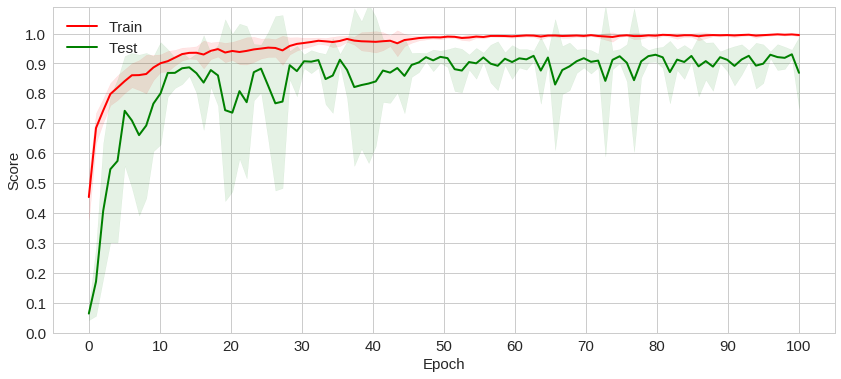

In [25]:
plot_mean_acc(history)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

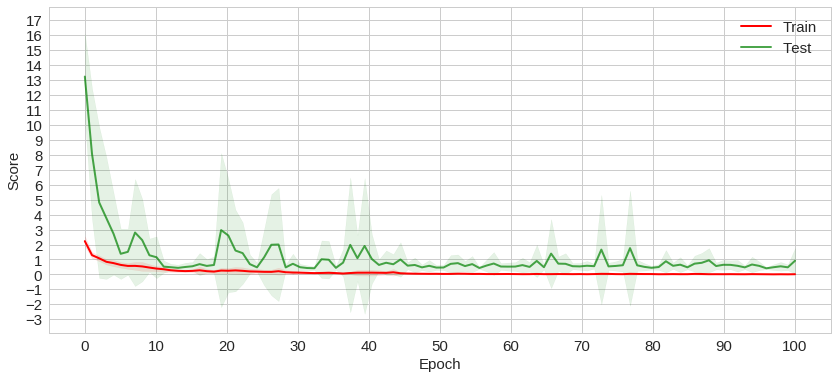

In [27]:
plot_mean_loss(history)